In [1]:
import cbc, cbc_dp
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyqtgraph as pg
import pickle
import pygmo
from numpy import ma
from scipy import constants
from scipy.ndimage import median_filter, label, labeled_comprehension, binary_fill_holes, binary_closing
from scipy.ndimage import binary_dilation
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cor_path = "exp_results/scan_{0:05}/scan_streaks_{0:05}.h5"
cor_data_path = 'corrected_data/corrected_data'
streaks_mask_path = 'corrected_data/streaks_mask'
bgd_path = 'corrected_data/background'
data_path = 'data/data'
mask_path = 'data/mask'

f135 = h5py.File(cor_path.format(135), 'r')
b12_cor_data = f135[cor_data_path][:]
b12_streaks_mask = f135[streaks_mask_path][:]
b12_data = f135[data_path][:]
b12_mask = f135[mask_path][:]
b12_bgd = f135[bgd_path][:]
frame_shape = b12_mask.shape
f135.close()

In [3]:
pix_size = 75 * 1e-3
wavelength = constants.h * constants.c / 17000 / constants.e * 1e3
rot_axis = np.array([0., 1., 0.])
b12_det_pos = np.array([115.2017197 , 129.0707665 ,  98.71582009])
# b12_det_pos = np.array([115.29697554, 129.16733852, 99.88790367])
lys_det_pos = np.array([1480 * pix_size, 1155 * pix_size, 150.0])
b12_exp = cbc_dp.ScanSetup(rot_axis=rot_axis,
                           pix_size=pix_size,
                           det_pos=b12_det_pos)
pupil_size = np.radians([0.65, 1.05])

In [4]:
rec_basis_new = np.array([[0.00906475, -0.04583905, -0.00082416],
                          [0.03227241, 0.00576972, 0.00194436],
                          [0.0016247, 0.00172209, -0.02941539]])
b12_det_pos_new = np.array([115.27911592, 128.57856985, 100.41825068])
b12_exp_new = cbc_dp.ScanSetup(rot_axis=rot_axis,
                               pix_size=pix_size,
                               det_pos=b12_det_pos_new)

In [5]:
f135 = h5py.File(cor_path.format(135), 'r')
b12_scan = cbc_dp.ScanStreaks(raw_lines=f135['streaks/lines'][:],
                              exp_set=b12_exp_new,
                              frame_idxs=f135['streaks/frame_idxs'][:])
f135.close()
b12_scan = cbc_dp.ScanStreaks.import_series(list(b12_scan))
b12_qs = b12_scan.kout_ref(np.radians(np.arange(101)))
basis_full = b12_qs.index()
rec_basis_full = cbc.rec_basis(basis_full)
b12_scan.size

13099

# Data processing pipeline

In [5]:
%load_ext cython

In [5]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def index_kout_lines(float_t[:, :, ::1] vot_vec, float_t num_ap_x, float_t num_ap_y):
    """
    Return source lines coordinates for a diffraction streaks model

    source - source line origins
    rec_vec - reciprocal vectors
    num_ap_x, num_ap_y - numerical apertires in x- and y-axes
    """
    cdef:
        int a = vot_vec.shape[0], b = vot_vec.shape[1], kk, i, j, k
        uint8_t[:, ::1] mask = np.zeros((a, b), dtype=np.uint8)
        float_t rec_abs, source_phi, source_th, source_x, source_y, source_z
        float_t source_prd, coeff1, coeff2, alpha, betta, gamma, delta, sol_1, sol_2
        float_t[::1] bounds = np.array([num_ap_x, -num_ap_x, num_ap_y, -num_ap_y], dtype=np.float64)
        float_t[:, :, :, ::1] source_lines = np.zeros((a, b, 2, 3), dtype=np.float64)
    for i in range(a):
        for j in range(b):
            rec_abs = sqrt(vot_vec[i, j, 0]**2 + vot_vec[i, j, 1]**2 + vot_vec[i, j, 2]**2)
            source_phi = atan2(vot_vec[i, j, 1], vot_vec[i, j, 0])
            source_th = acos(-vot_vec[i, j, 2] / rec_abs) - acos(rec_abs / 2)
            source_x = -sin(source_th) * cos(source_phi)
            source_y = -sin(source_th) * sin(source_phi)
            source_z =  cos(source_th)
            source_prd = source_x * vot_vec[i, j, 0] + source_y * vot_vec[i, j, 1] + source_z * vot_vec[i, j, 2]
            kk = 0
            for k in range(4):
                coeff1 = source_prd - bounds[k] * vot_vec[i, j, k // 2]
                coeff2 = vot_vec[i, j, (3 - k) // 2]
                alpha = coeff2**2 + vot_vec[i, j, 2]**2
                betta = coeff2 * coeff1
                gamma = coeff1**2 - vot_vec[i, j, 2]**2 * (1 - bounds[k]**2)
                delta = betta**2 - alpha * gamma
                sol_1 = (betta + sqrt(delta)) / alpha
                sol_2 = (betta - sqrt(delta)) / alpha
                if abs(sol_1) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_1
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_1**2)
                    kk += 1
                if delta != 0 and abs(sol_2) < abs(bounds[3 - k]):
                    source_lines[i, j, kk, k // 2] = vot_vec[i, j, k // 2] + bounds[k]
                    source_lines[i, j, kk, (3 - k) // 2] = vot_vec[i, j, (3 - k) // 2] + sol_2
                    source_lines[i, j, kk, 2] = vot_vec[i, j, 2] + sqrt(1 - bounds[k]**2 - sol_2**2)
                    kk += 1
                if kk == 2:
                    mask[i, j] = 1
                    break
    return np.asarray(source_lines), np.asarray(mask).astype(bool)

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def kout_source(float_t[:, :, ::1] kout_exp):
    cdef:
        int a = kout_exp.shape[0], i
        float_t dkout_x, dkout_y, prod, source_x, source_y
        float_t[:, ::1] kout_source = np.empty((a, 3), dtype=np.float64)
    for i in range(a):
        dkout_x = kout_exp[i, 1, 0] - kout_exp[i, 0, 0]
        dkout_y = kout_exp[i, 1, 1] - kout_exp[i, 0, 1]
        prod = kout_exp[i, 1, 0] * dkout_y - kout_exp[i, 1, 1] * dkout_x
        kout_source[i, 0] = dkout_y * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 1] = -dkout_x * prod / (dkout_x**2 + dkout_y**2)
        kout_source[i, 2] = sqrt(1 - kout_source[i, 0]**2 - kout_source[i, 1]**2)
    return np.asarray(kout_source)

In [76]:
f135_2 = h5py.File("exp_results/scan_{0:05}/scan_corrected_{0:05}.h5".format(135), 'r')
b12_bgd2 = f135_2['corrected_data/background'][:]
b12_cor_data2 = f135_2['corrected_data/corrected_data'][:]
with h5py.File("exp_results/scan_{0:05}/scan_raw_{0:05}.h5".format(134), 'r') as file:
    exp_bgd = file['data/data'][0]
bad_mask = np.load('cbc_dp/utils/b12_mask.npy')
f135_2.close()

In [217]:
bad_mask = np.load('cbc_dp/utils/b12_mask.npy')
with h5py.File("exp_results/scan_{0:05}/scan_raw_{0:05}.h5".format(134), 'r') as file:
    exp_bgd = file['data/data'][0]
scan = cbc_dp.open_scan('b12_2', 135)

In [218]:
cor_data = cbc_dp.CorrectedData(b12_data, exp_bgd, bad_mask)

In [38]:
cbc_dp.CorrectedData.streak_width = 13
cor_data._mask_data()

In [263]:
norm_data = cbc_dp.NormalizedData(b12_cor_data, b12_streaks_mask)

In [245]:
line_detector = cbc_dp.LineSegmentDetector(scale=0.5, sigma_scale=0.5)
b12_scan = line_detector.det_scan(norm_data.norm_data, b12_exp, 10)
b12_scan.size

13099

In [248]:
out_file = scan._create_outfile(tag='streaks')
scan._save_parameters(out_file)
scan._save_data(out_file)
cor_data.save(out_file)
b12_scan.save(out_file)
out_file.close()

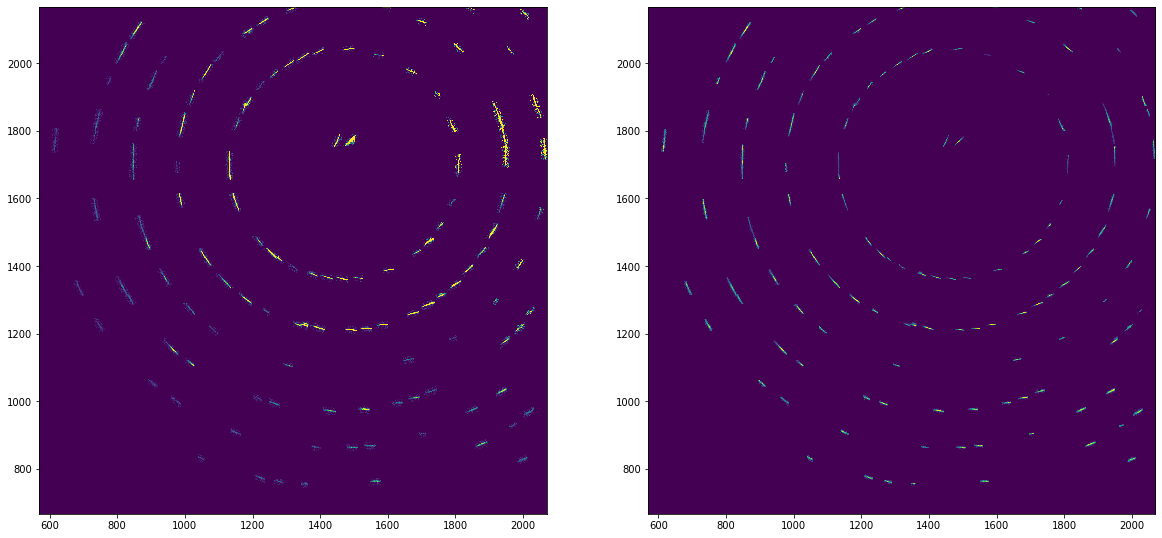

In [268]:
%matplotlib inline
frame_idx = 0
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx] * b12_streaks_mask[frame_idx], vmin=0, vmax=50)
axes[1].imshow(norm_data.norm_data[frame_idx], vmin=0, vmax=0.7)
for ax in axes:
    ax.set_xlim(570, 2070)
    ax.set_ylim(667, 2167)
# plt.show()
plt.savefig('figures/norm_frame.pdf')

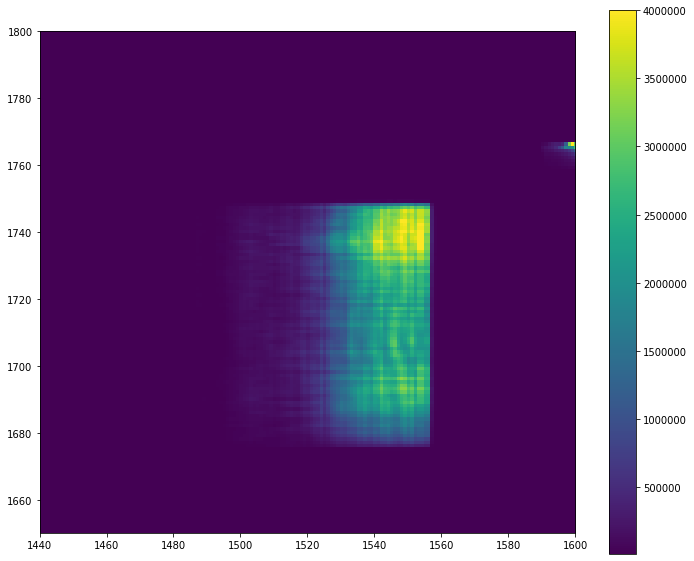

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
pos = ax.imshow(b12_data[0] * b12_mask, vmin=10000, vmax=4000000)
fig.colorbar(pos, ax=ax)
ax.set_xlim(1440, 1600)
ax.set_ylim(1650, 1800)
# plt.show()
plt.savefig('figures/pupil.pdf')

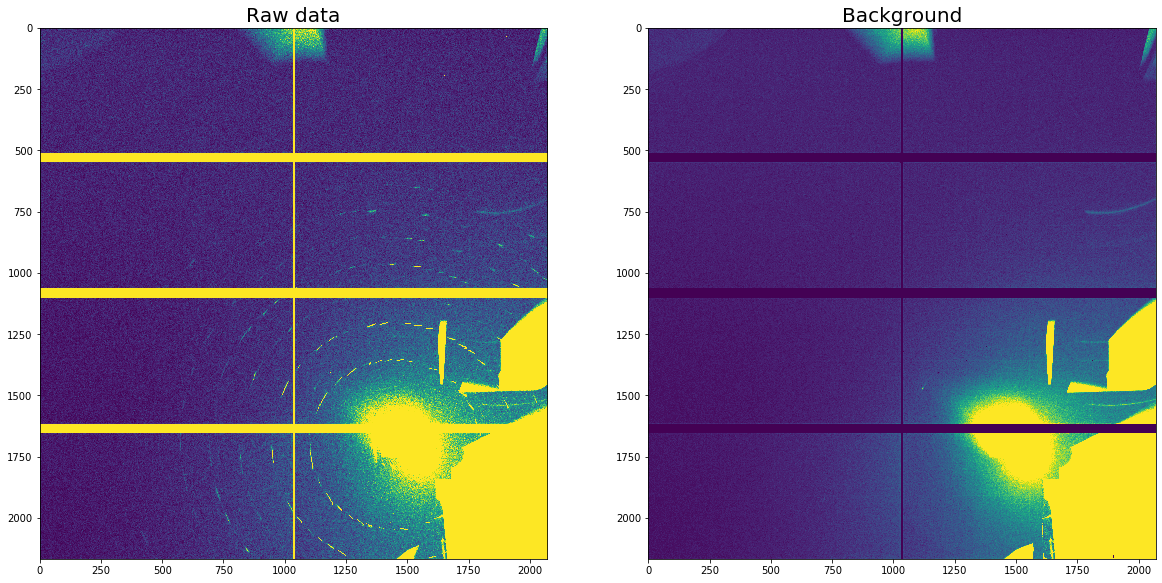

In [84]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_data[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Raw data', fontsize=20)
axes[1].imshow(b12_bgd[frame_idx], vmin=0, vmax=50)
axes[1].set_title('Background', fontsize=20)
plt.show()
# plt.savefig('figures/dp_pipeline1.pdf')

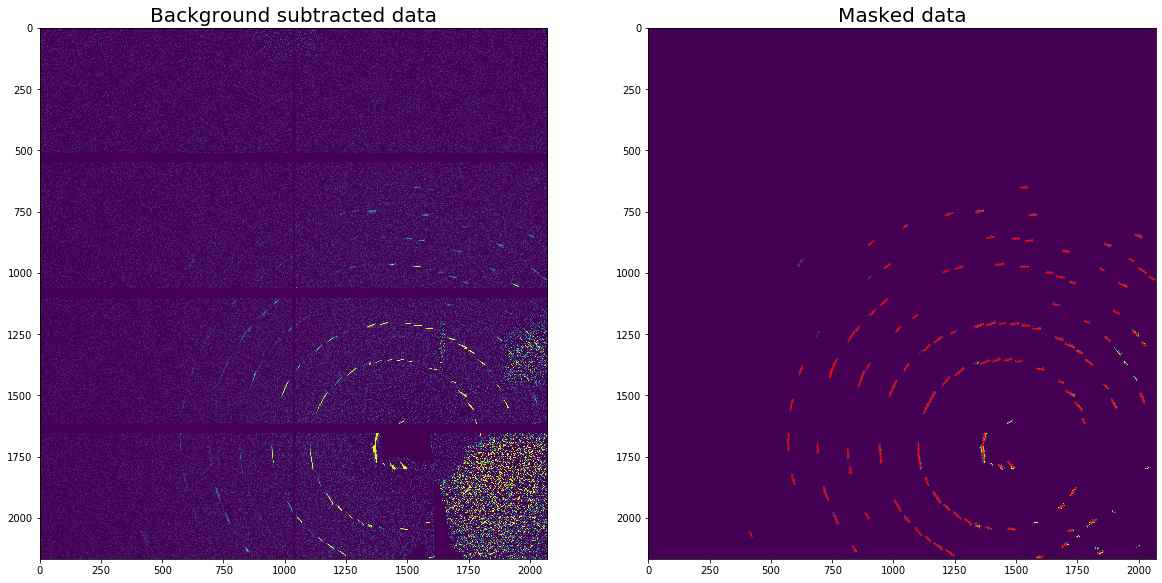

In [82]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Background subtracted data', fontsize=20)
axes[1].imshow(b12_cor_data[frame_idx] * b12_streaks_mask[frame_idx], vmin=0, vmax=50)
axes[1].set_title('Masked data', fontsize=20)
for line in b12_scan[frame_idx].raw_lines:
    axes[1].plot(line[:, 0], line[:, 1], 'r')
plt.show()
# plt.savefig('figures/dp_pipeline2.pdf')

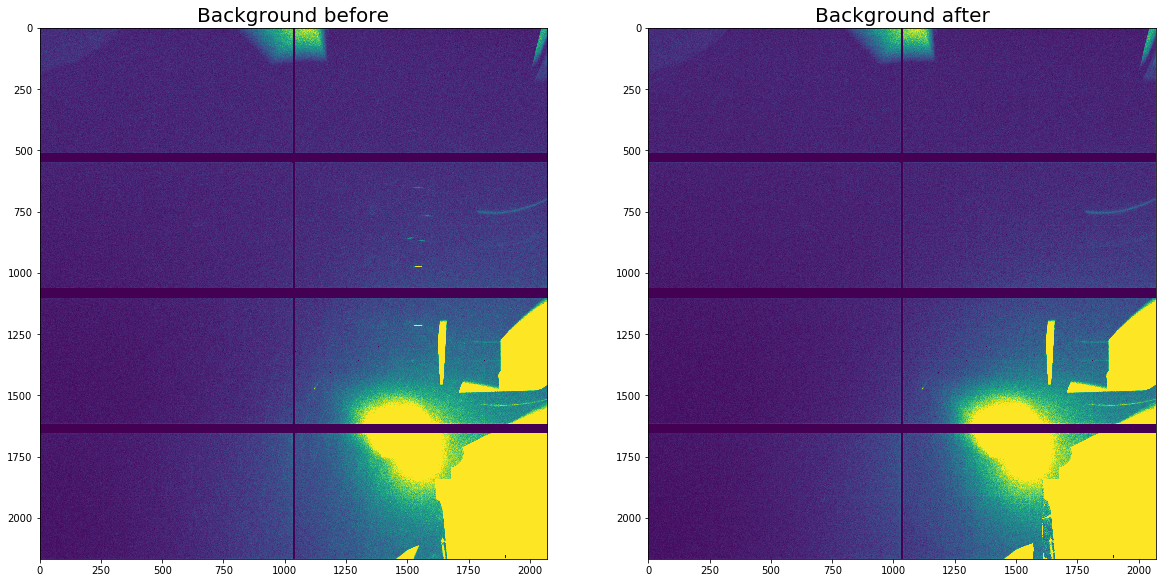

In [77]:
%matplotlib inline
frame_idx = 1
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_bgd2[frame_idx], vmin=0, vmax=50)
axes[1].imshow(b12_bgd[frame_idx], vmin=0, vmax=50)
axes[0].set_title('Background before', fontsize=20)
axes[1].set_title('Background after', fontsize=20)
plt.show()
# plt.savefig('figures/background.pdf')

# Pattern refinement

In [35]:
frame_idx = 6
rec_basis = rec_basis_new.dot(b12_exp_new.rotation_matrix(-np.radians(frame_idx)).T)
rec_sizes = np.sqrt((rec_basis**2).sum(axis=-1))
start_point = np.concatenate((b12_det_pos_new, rec_sizes, np.zeros(3)))
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx],
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=([0.007, 0.014, 0.03], 0.03, 1.5),
                      pen_coeff=10)
algo = pygmo.algorithm(pygmo.de(gen=1000))
prob = pygmo.problem(rot_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
champion = pop.champion_x
print(rot_tf.fitness(start_point), pop.champion_f, sep='\n')
print(champion[:3])
print(champion[6:])

[0.0201780028298927]
[0.00535976]
[114.94239299 130.50406396  99.47474031]
[ 1.27357875 -0.00756766 -1.26062806]


In [31]:
frame_idx = 80
rec_basis = rec_basis_new.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
rec_sizes = np.sqrt((rec_basis**2).sum(axis=-1))
start_point = np.concatenate((b12_det_pos_new, rec_sizes, np.zeros(3)))
rot_tf = cbc_dp.RCBI(streaks=b12_scan[frame_idx],
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=([0.007, 0.014, 0.06], 0.05, 0.15),
                      pen_coeff=10)
champion = index_sol[frame_idx]
print(rot_tf.fitness(start_point), rot_tf.fitness(champion), sep='\n')
print(champion[:3])
print(champion[6:])

[0.007410083178963989]
[0.002588223554957703]
[115.29803825 128.89384788 101.03023426]
[-0.31395318  0.01583759  0.3149938 ]


In [73]:
model = cbc_dp.RectModel(rec_lat=cbc_dp.BallLattice(rot_tf.rec_basis(champion), 0.75),
                         num_ap=pupil_size)
model_lines = rot_tf.det_pts(model.kout_lines(), champion)
model_pts = rot_tf.det_pts(model.kout(), champion)

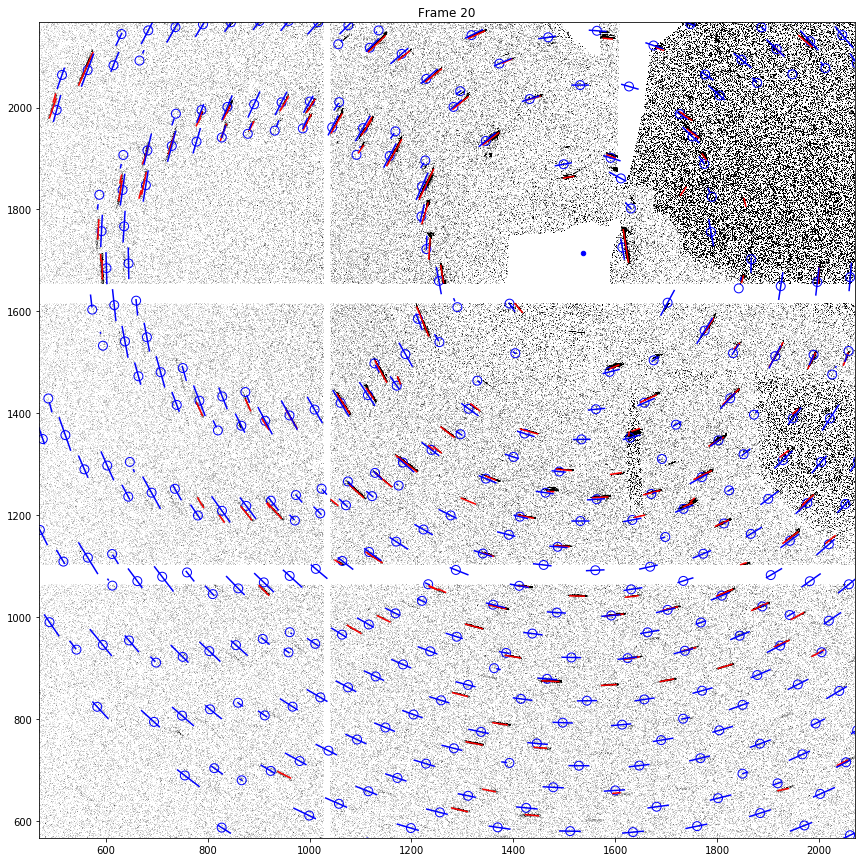

In [74]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx],
          vmin=0, vmax=20, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
plt.scatter(rot_tf.exp_set.det_pos[0] / pix_size, rot_tf.exp_set.det_pos[1] / pix_size, 20, 'b')
ax.set_xlim(470, 2070)
ax.set_ylim(567, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

In [26]:
hkl_idxs = full_tf.hkl_idxs(champion)
model = cbc_dp.RectModel(rec_lat=cbc_dp.RecLattice(full_tf.rec_basis(champion), hkl_idxs),
                         num_ap=pupil_size)
model_lines = full_tf.det_pts(model.kout_lines(), champion)
model_pts = full_tf.det_pts(model.kout(), champion)

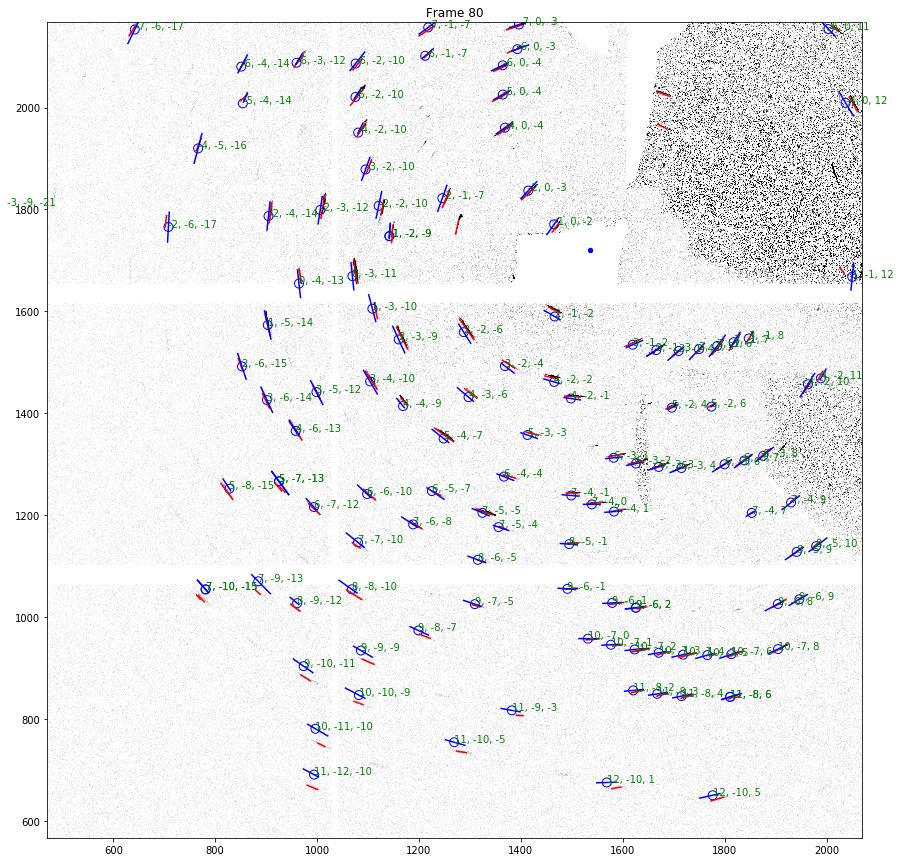

In [27]:
%matplotlib inline
exp_pts = b12_scan[frame_idx].raw_lines.mean(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(b12_cor_data[frame_idx], vmin=0, vmax=50, cmap='gray_r')
for line in b12_scan[frame_idx].raw_lines:
    ax.plot(line[..., 0], line[..., 1], 'r')
ax.scatter(model_pts[..., 0], model_pts[..., 1], s=80, facecolors='none', edgecolors='b')
for line in model_lines:
    ax.plot(line[..., 0], line[..., 1], 'b')
plt.scatter(b12_det_pos[0] / pix_size, b12_det_pos[1] / pix_size, 20, 'b')
for pt, hkl in zip(model_pts, model.hkl_idxs):
    ax.text(pt[0], pt[1], '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl.astype(np.int)), color='g', fontsize=10)
ax.set_xlim(470, 2070)
ax.set_ylim(567, 2167)
ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

# Scan refiniment

Refinement vector:

    0-size        - x0 (sample position)
    size-2*size   - y0 (sample position)
    2*size-3*size - z0 (sample position)
    3*size-4*size - thetas (angles of rotation)
    4*size        - alpha (rot_axis)
    4*size + 1    - betta (rot_axis)
    4*size + 2:   - rec_basis (basis vectors matrix)

In [28]:
frame_idx = 80
thetas = -np.radians(np.arange(0, 101))
frame_scan = cbc_dp.ScanStreaks(b12_scan[frame_idx].raw_lines, b12_exp, 
                                frame_idx * np.ones(b12_scan[frame_idx].size, dtype=np.int))
start_vec = np.concatenate((np.repeat(b12_det_pos, 101),
                            thetas, np.pi / 2 * np.ones(2), rec_basis_full.ravel()))
scan_tf = cbc_dp.ScanCBI(streaks=frame_scan, num_ap=pupil_size, rec_basis=rec_basis_full,
                  thetas=thetas, tol=([0.007, 0.014, 0.06], 0.002, 0.02, 0.05), pen_coeff=10)

rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(thetas[frame_idx]).T)
rec_sizes = np.sqrt((rec_basis**2).sum(axis=-1))
start_point = np.concatenate((b12_det_pos, rec_basis.ravel()))
full_tf = cbc_dp.FCBI(streaks=b12_scan[frame_idx], num_ap=pupil_size,
                      rec_basis=rec_basis, tol=([0.007, 0.014, 0.06], 0.05, 0.15))

print(full_tf.fitness(start_point))
print(scan_tf.fitness(start_vec))
kout_exp_f = full_tf.kout_exp(start_point)
vot_vec_f = full_tf.voting_vectors(start_point, kout_exp_f)
kout_exp = scan_tf.kout_exp(start_vec)
vot_vec = scan_tf.voting_vectors(start_vec, kout_exp)
print((kout_exp_f == kout_exp).all())
print(np.isclose(vot_vec_f, vot_vec).all())

[0.007534889900150634]
[0.007534889900150649]
True
True


In [45]:
scan_tf.fitness(pop.champion_x), scan_tf.fitness(start_vec)

([0.016128306599183382], [0.009453362400319328])

In [ ]:
thetas = -np.radians(np.arange(101))
start_vec = np.concatenate((np.repeat(b12_det_pos_new, 101),
                            thetas, np.pi / 2 * np.ones(2),
                            rec_basis_new.ravel()))
scan_tf = cbc_dp.ScanCBI(streaks=b12_scan, num_ap=pupil_size, rec_basis=rec_basis_new,
                         thetas=thetas, tol=([0.007, 0.014, 0.06], 0.002, 0.02, 0.05))
algo = pygmo.algorithm(pygmo.de(gen=1000))
prob = pygmo.problem(scan_tf)
pop = pygmo.population(prob, size=50)
pop = algo.evolve(pop)
champion = pop.champion_x
print(scan_tf.fitness(start_vec), scan_tf.fitness(champion), sep='\n')

# Indexing results

In [30]:
index_list = h5py.File('exp_results/b12_index_3.h5', 'r')['data/index_sol'][:]
index_f = h5py.File('exp_results/b12_index_3.h5', 'r')['data/index_f'][:]
idxs = (np.argmin(index_f, axis=0), np.arange(index_list.shape[1]))
index_sol = index_list[idxs]

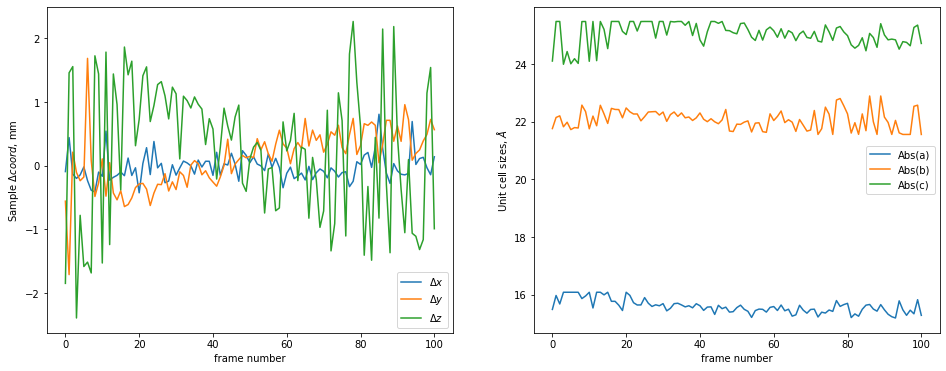

In [7]:
%matplotlib inline
rec_lengths = np.sqrt((rec_basis_full**2).sum(axis=-1))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(index_sol[:, 0] - b12_det_pos_new[0], label='$\Delta x$')
axes[0].plot(index_sol[:, 1] - b12_det_pos_new[1], label='$\Delta y$')
axes[0].plot(index_sol[:, 2] - b12_det_pos_new[2], label='$\Delta z$')
axes[0].set_xlabel('frame number')
axes[0].set_ylabel('Sample $\Delta coord$, mm')
axes[0].legend()
axes[1].plot(wavelength / index_sol[:, 3] * 1e7, label='Abs(a)')
axes[1].plot(wavelength / index_sol[:, 4] * 1e7, label='Abs(b)')
axes[1].plot(wavelength / index_sol[:, 5] * 1e7, label='Abs(c)')
axes[1].set_xlabel('frame number')
axes[1].set_ylabel('Unit cell sizes, $\AA$')
axes[1].legend()
plt.show()
# plt.savefig('figures/index_sol_rot.pdf')

In [8]:
index_list = h5py.File('exp_results/b12_index_2.h5', 'r')['data/index_sol'][:]
index_f = h5py.File('exp_results/b12_index_2.h5', 'r')['data/index_f'][:]
idxs = (np.argmin(index_f, axis=0), np.arange(index_list.shape[1]))
index_sol = index_list[idxs]

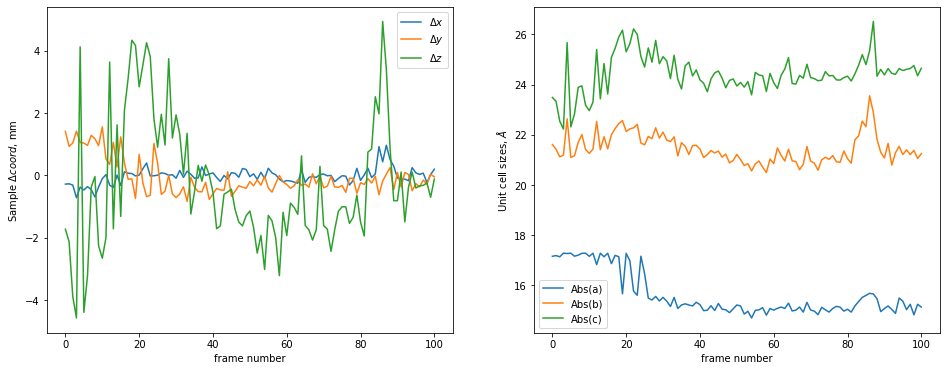

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
rec_mat = index_sol[:, 3:].reshape((101, 3, 3))
rec_sizes = np.sqrt((rec_mat**2).sum(axis=-1))
or_mats = rec_mat / rec_sizes[:, :, None]
alpha12 = np.arccos((or_mats[:, 0] * or_mats[:, 1]).sum(axis=1))
alpha23 = np.arccos((or_mats[:, 1] * or_mats[:, 2]).sum(axis=1))
alpha13 = np.arccos((or_mats[:, 0] * or_mats[:, 2]).sum(axis=1))
axes[0].plot(index_sol[:, 0] * b12_det_pos[0], label='$\Delta x$')
axes[0].plot(index_sol[:, 1] * b12_det_pos[1], label='$\Delta y$')
axes[0].plot(index_sol[:, 2] * b12_det_pos[2], label='$\Delta z$')
axes[0].set_xlabel('frame number')
axes[0].set_ylabel('Sample $\Delta coord$, mm')
axes[0].legend()
axes[1].plot(wavelength / rec_sizes[:, 0] * 1e7, label='Abs(a)')
axes[1].plot(wavelength / rec_sizes[:, 1] * 1e7, label='Abs(b)')
axes[1].plot(wavelength / rec_sizes[:, 2] * 1e7, label='Abs(c)')
axes[1].set_xlabel('frame number')
axes[1].set_ylabel('Unit cell sizes, $\AA$')
axes[1].legend()
plt.show()
# plt.savefig('figures/index_sol_full.pdf')

In [11]:
index_list = h5py.File('exp_results/b12_index_scan.h5', 'r')['data/index_sol'][:]
index_f = h5py.File('exp_results/b12_index_scan.h5', 'r')['data/index_f'][:]
idxs = (np.argmin(index_f, axis=0), np.arange(index_list.shape[1]))
index_sol = index_list[idxs]

In [16]:
index_f

array([0.01470838, 0.01450786, 0.01474922, 0.01476506, 0.01478388,
       0.01510171, 0.01501758, 0.01506747, 0.01445269, 0.01484381,
       0.01497246, 0.01497862, 0.01506353, 0.0148807 , 0.01475785,
       0.01477367, 0.01474519, 0.01499843, 0.01501223, 0.01503546])

IndexError: too many indices for array

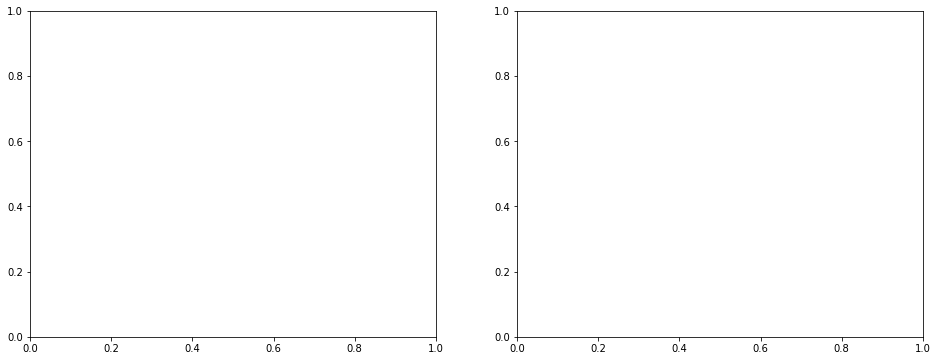

In [12]:
%matplotlib inline
rec_lengths = np.sqrt((rec_basis_full**2).sum(axis=-1))
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(index_sol[:, 0] - b12_det_pos_new[0], label='$\Delta x$')
axes[0].plot(index_sol[:, 1] - b12_det_pos_new[1], label='$\Delta y$')
axes[0].plot(index_sol[:, 2] - b12_det_pos_new[2], label='$\Delta z$')
axes[0].set_xlabel('frame number')
axes[0].set_ylabel('Sample $\Delta coord$, mm')
axes[0].legend()
axes[1].plot(wavelength / index_sol[:, 3] * 1e7, label='Abs(a)')
axes[1].plot(wavelength / index_sol[:, 4] * 1e7, label='Abs(b)')
axes[1].plot(wavelength / index_sol[:, 5] * 1e7, label='Abs(c)')
axes[1].set_xlabel('frame number')
axes[1].set_ylabel('Unit cell sizes, $\AA$')
axes[1].legend()
plt.show()
# plt.savefig('figures/index_sol_rot.pdf')

In [8]:
kin_list, hkl_list = [], []
thetas = np.radians(np.arange(101))
for theta, champion, b12_frame in zip(thetas, index_sol, b12_scan):
    rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-theta).T)
    full_tf = cbc_dp.RCBI(streaks=b12_frame,
                          num_ap=pupil_size,
                          rec_basis=rec_basis,
                          tol=([0.007, 0.014, 0.06], 0.03, 1.5))
    kout_exp = full_tf.kout_exp(champion)
    hkl_idxs = full_tf.hkl_idxs(champion)
    rec_vec = hkl_idxs.dot(full_tf.rec_basis(champion))
    hkl_list.append(hkl_idxs)
    kin_list.append(kout_exp - rec_vec[:, None])
kin_arr = np.concatenate(kin_list)
hkl_arr = np.concatenate(hkl_list)

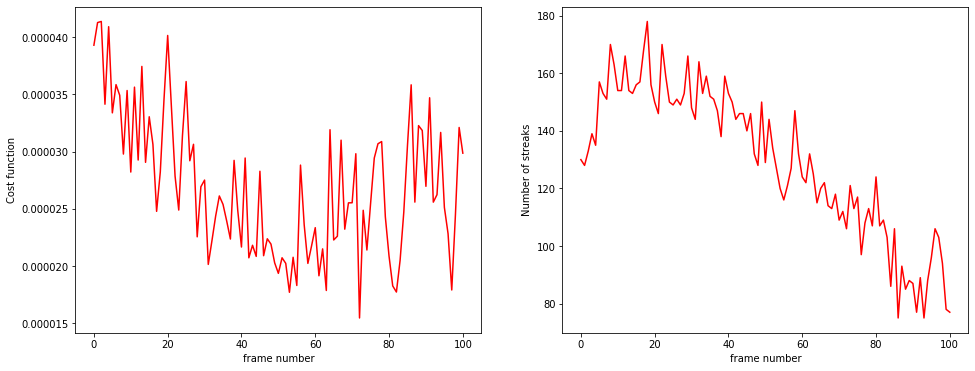

In [55]:
%matplotlib inline
counts = np.unique(b12_scan.frame_idxs, return_counts=True)[1]
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(np.min(index_f, axis=0) / counts, 'r')
axes[0].set_xlabel('frame number')
axes[0].set_ylabel('Cost function')
axes[1].plot(counts, 'r')
axes[1].set_xlabel('frame number')
axes[1].set_ylabel('Number of streaks')
plt.show()

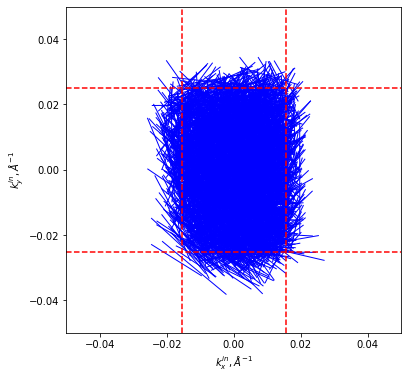

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6))
NA_x, NA_y = pupil_size[0], pupil_size[1]
ax = fig.add_subplot(111)
for kin_chunk in kin_list[30:40]:
    for line in kin_chunk:
        ax.plot(line[..., 0] / wavelength * 1e-7,
                line[..., 1] / wavelength * 1e-7, 'b', linewidth=1)
# for line in kin_list[20]:
#     ax.plot(line[..., 0] / wavelength * 1e-7,
#             line[..., 1] / wavelength * 1e-7, 'b', linewidth=1)
ax.plot(np.linspace(-0.05, 0.05), NA_y / wavelength * 1e-7 * np.ones(50), '--r')
ax.plot(np.linspace(-0.05, 0.05), -NA_y / wavelength * 1e-7 * np.ones(50), '--r')
ax.plot(NA_x / wavelength * 1e-7 * np.ones(50), np.linspace(-0.05, 0.05), '--r')
ax.plot(-NA_x / wavelength * 1e-7 * np.ones(50), np.linspace(-0.05, 0.05), '--r')
ax.set_xlim(-0.05, 0.05)
ax.set_ylim(-0.05, 0.05)
ax.set_xlabel('$k^{in}_x, \AA^{-1}$')
ax.set_ylabel('$k^{in}_y, \AA^{-1}$')
plt.show()
# plt.savefig('figures/kin_pupil.pdf')

## Intensity estimation

In [9]:
struct = np.zeros((15, 15))
struct[7, 7] = 1
struct = binary_dilation(struct, iterations=7).astype(np.uint8)
struct

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [10]:
%load_ext cython

In [11]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t
ctypedef cnp.uint64_t uint_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def i_sigma(uint8_t[:, ::1] streaks_mask, int_t[:, ::1] cor_data, uint_t[:, ::1] background):
    """
    Return streak's intensity and Poisson noise

    streaks_mask - streak's mask
    cor_data - background subtracted diffraction data
    background - background
    """
    cdef:
        int_t a = streaks_mask.shape[0], b = streaks_mask.shape[1], count = 0, I = 0, i, j
        float_t bgd_mean = 0, bgd_var = 0, bgd_sigma, delta
    for i in range(a):
        for j in range(b):
            if streaks_mask[i, j]:
                count += 1
                delta = (background[i, j] - bgd_mean)
                bgd_mean += delta / count
                bgd_var += (background[i, j] - bgd_mean) * delta
                I += cor_data[i, j]
    bgd_sigma = max(bgd_mean * count, bgd_var)
    return I, sqrt(I + bgd_sigma)

In [43]:
def frame_i_sigma(frame_streaks, hkl_idxs, cor_data, bgd, frame_mask):
    """
    Return detected streaks intensities (I) and Poisson noise (sigma)

    cor_data - background subtracted data
    bgd - background data
    hkl_idxs - hkl indices
    """
    hkl_uniq = np.unique(hkl_idxs, axis=0)
    i_list, s_list = [], []
    for hkl in hkl_uniq:
        idxs = np.where((hkl_idxs == hkl).all(axis=1))
        lines = frame_streaks.raw_lines[idxs]
        length = np.sqrt((lines[:, 1, 0] - lines[:, 0, 0])**2 + (lines[:, 1, 1] - lines[:, 0, 1])**2).sum()
        line_mask = cbc_dp.utils.streaks_mask(lines=lines, structure=struct,
                                              width=1, shape_x=bgd.shape[0],
                                              shape_y=bgd.shape[1])
        i_tot, sigma = i_sigma(line_mask * frame_mask, cor_data, bgd)
        i_list.append(i_tot / length)
        s_list.append(sigma / length)
    return hkl_uniq, np.array(i_list), np.array(s_list)

def scan_i_sigma(scan_streaks, hkl_idxs, cor_data, bgd, masks):
    """
    Return detected streaks intensities (I) and Poisson noise (sigma)

    cor_data - background subtracted data
    bgd - background data
    hkl_idxs - hkl indices
    """
    frame_idxs = np.unique(scan_streaks.frame_idxs)
    i_list, s_list, hkl_list, idx_list = [], [], [], []
    for frame_idx in frame_idxs:
        idxs = np.where(scan_streaks.frame_idxs == frame_idx)
        streaks = cbc_dp.FrameStreaks(lines=scan_streaks.raw_lines[idxs],
                                      exp_set=scan_streaks.exp_set)
        hkl_arr, i_arr, s_arr = frame_i_sigma(frame_streaks=streaks,
                                              hkl_idxs=hkl_idxs[idxs],
                                              cor_data=cor_data[frame_idx],
                                              bgd=bgd[frame_idx],
                                              frame_mask=masks[frame_idx])
        hkl_list.append(hkl_arr)
        i_list.append(i_arr)
        s_list.append(s_arr)
        idx_list.append(frame_idx * np.ones(i_arr.size))
    return np.concatenate(hkl_list), np.concatenate(i_list), np.concatenate(s_list), np.concatenate(idx_list)

In [44]:
def frame_i_sigma(frame_streaks, hkl_idxs, cor_data, bgd, frame_mask):
    """
    Return detected streaks intensities (I) and Poisson noise (sigma)

    cor_data - background subtracted data
    bgd - background data
    hkl_idxs - hkl indices
    """
    hkl_uniq = np.unique(hkl_idxs, axis=0)
    i_list, s_list, len_list = [], [], []
    for hkl in hkl_uniq:
        idxs = np.where((hkl_idxs == hkl).all(axis=1))
        lines = frame_streaks.raw_lines[idxs]
        length = np.sqrt((lines[:, 1, 0] - lines[:, 0, 0])**2 + (lines[:, 1, 1] - lines[:, 0, 1])**2).sum()
        line_mask = cbc_dp.utils.streaks_mask(lines=lines, structure=struct,
                                              width=1, shape_x=bgd.shape[0],
                                              shape_y=bgd.shape[1])
        i_tot, sigma = i_sigma(line_mask * frame_mask, cor_data, bgd)
        i_list.append(i_tot / length)
        s_list.append(sigma / length)
        len_list.append(length)
    return hkl_uniq, np.array(i_list), np.array(s_list), np.array(len_list)

def scan_i_sigma(scan_streaks, hkl_idxs, cor_data, bgd, masks):
    """
    Return detected streaks intensities (I) and Poisson noise (sigma)

    cor_data - background subtracted data
    bgd - background data
    hkl_idxs - hkl indices
    """
    frame_idxs = np.unique(scan_streaks.frame_idxs)
    i_list, s_list, hkl_list, idx_list, len_list = [], [], [], [], []
    for frame_idx in frame_idxs:
        idxs = np.where(scan_streaks.frame_idxs == frame_idx)
        streaks = cbc_dp.FrameStreaks(lines=scan_streaks.raw_lines[idxs],
                                      exp_set=scan_streaks.exp_set)
        hkl_arr, i_arr, s_arr, len_arr = frame_i_sigma(frame_streaks=streaks,
                                                       hkl_idxs=hkl_idxs[idxs],
                                                       cor_data=cor_data[frame_idx],
                                                       bgd=bgd[frame_idx],
                                                       frame_mask=masks[frame_idx])
        hkl_list.append(hkl_arr)
        i_list.append(i_arr)
        s_list.append(s_arr)
        len_list.append(len_arr)
        idx_list.append(frame_idx * np.ones(i_arr.size))
    return np.concatenate(hkl_list), np.concatenate(i_list), np.concatenate(s_list), np.concatenate(len_list), np.concatenate(idx_list)

In [45]:
hkl_scan, i_scan, s_scan, len_scan, scan_idxs = scan_i_sigma(b12_scan, hkl_arr, b12_cor_data, b12_bgd, b12_streaks_mask)

In [47]:
i_scan.min()

-303.46006509865884

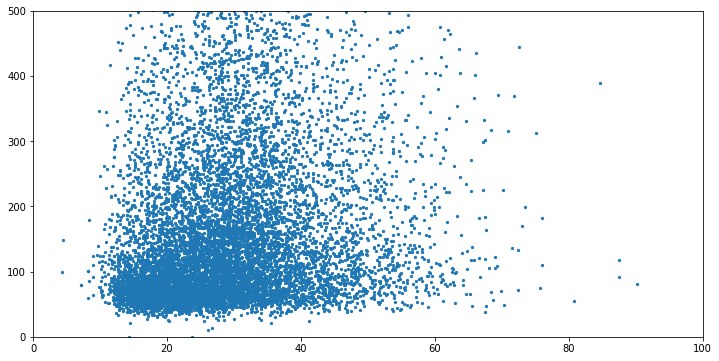

In [50]:
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.scatter(len_scan, i_scan, 5)
ax.set_ylim(0, 500)
ax.set_xlim(0, 100)
plt.show()

In [21]:
idx0, idx1 = 76, 77
hkl0_arr, hkl1_arr = hkl_dict[idx0], hkl_dict[idx1]
cidx0, cidx1 = np.where((hkl0_arr[:, None] == hkl1_arr[None, :]).all(axis=-1))
i0_arr, i1_arr = i_dict[idx0], i_dict[idx1]
print('Scale: {:f}\n'.format(np.median(i1_arr[cidx1] / i0_arr[cidx0])))
ri_arr = np.abs(2 * (i1_arr[cidx1] - i0_arr[cidx0]) / (i1_arr[cidx1] + i0_arr[cidx0]))
for hkl, i0, i1, ri in zip(hkl0_arr[cidx0], i0_arr[cidx0], i1_arr[cidx1], ri_arr):
    print('{0[0]:-4d},{0[1]:-4d},{0[2]:-4d}:{1:-10.2f},{2:-10.2f},{3:-8.2f},{4:-8.2f}'.format(hkl, i0, i1, i1 / i0, ri))
print('\n\n')

Scale: 0.816891

  -6,  -1,  -6:    673.92,    825.62,    1.23,    0.20
  -6,   0,  -3:     81.47,    150.95,    1.85,    0.60
  -6,   1,   5:    262.27,    118.49,    0.45,    0.76
  -6,   1,   8:    237.98,    294.70,    1.24,    0.21
  -5,  -3, -11:    116.15,    176.63,    1.52,    0.41
  -5,  -1,  -6:    735.47,    233.76,    0.32,    1.04
  -5,   0,  -3:    228.75,    313.63,    1.37,    0.31
  -5,   1,  10:    392.00,    142.56,    0.36,    0.93
  -4,  -7, -17:    116.37,     60.30,    0.52,    0.63
  -4,   1,  10:     67.96,    251.99,    3.71,    1.15
  -3,  -1,  -6:    234.45,    108.30,    0.46,    0.74
  -3,   0,  -3:    191.59,   2625.21,   13.70,    1.73
  -3,   1,   3:   3930.52,   1322.98,    0.34,    0.99
  -2,  -5, -14:     80.74,     50.66,    0.63,    0.46
  -2,   1,   5:   1138.90,     37.09,    0.03,    1.87
  -2,   1,   8:   1169.77,    119.85,    0.10,    1.63
  -1,  -1,  -5:  10613.54,    332.32,    0.03,    1.88
   1,  -6, -14:    157.11,     64.54,    0.41,  

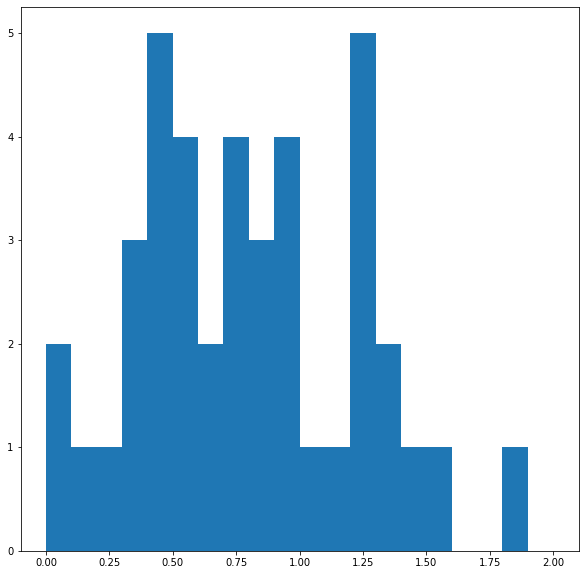

In [35]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.hist(i1_arr[cidx1] / i0_arr[cidx0], 20, range=(0, 2))
plt.show()

In [36]:
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(idx0)).T)
rot_tf = cbc_dp.RCBI(lines=b12_scan[idx0].raw_lines,
                      exp_set=b12_exp,
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=([0.025, 0.025, 0.05], 0.12),
                      pen_coeff=10)
champion = index_sol[idx0]
model = cbc_dp.RectModel(rec_lat=cbc_dp.RecLattice(full_tf.rec_basis(champion), hkl[None, :]),
                         num_ap=pupil_size)
model_lines = full_tf.det_pts(model.kout_lines(), champion)

TypeError: __init__() got an unexpected keyword argument 'lines'

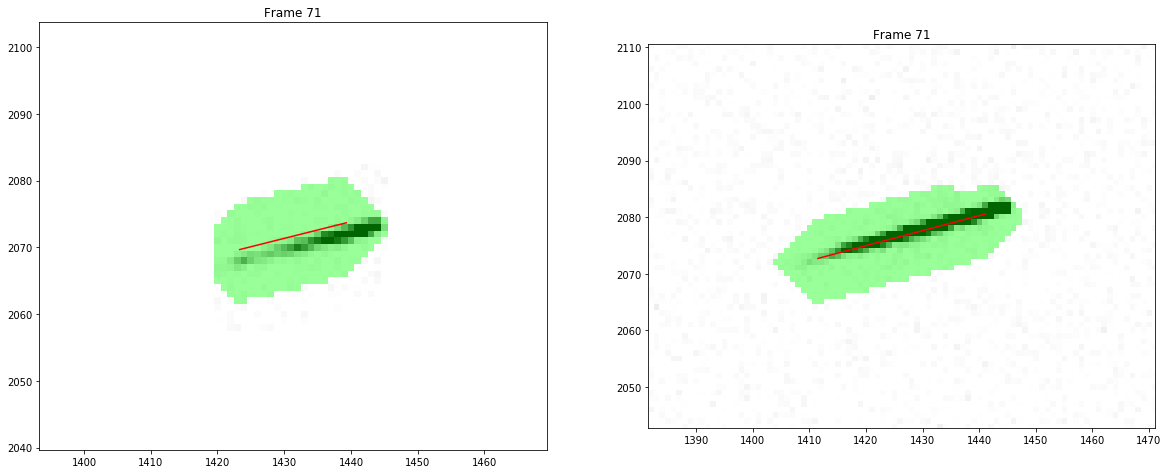

In [139]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
hkl = hkl0_arr[cidx0[np.where(ri_arr > 0.5)]][0]
# axes[0].imshow(b12_cor_data[idx0], vmin=0, vmax=300, cmap='gray_r')
axes[0].imshow(b12_cor_data[idx0] * b12_streaks_mask[idx0], vmin=0, vmax=300, cmap='gray_r')
axes[1].imshow(b12_cor_data[idx1], vmin=0, vmax=300, cmap='gray_r')
idxs0 = np.where((hkl_list[idx0] == hkl).all(axis=-1))
lines0 = b12_scan[idx0].raw_lines[idxs0]
mask0 = cbc_dp.utils.streaks_mask(lines=lines0, structure=struct,
                                  width=1, shape_x=frame_shape[0], shape_y=frame_shape[1])
for line in lines0:
    axes[0].plot(line[:, 0], line[:, 1], 'r')
for line in model_lines:
    axes[0].plot(line[:, 0], line[:, 1], 'b')
axes[0].imshow((b12_streaks_mask[idx0] * mask0)[..., None] * np.array([0, 1, 0, 0.4]))
idxs1 = np.where((hkl_list[idx1] == hkl).all(axis=-1))
lines1 = b12_scan[idx1].raw_lines[idxs1]
mask1 = cbc_dp.utils.streaks_mask(lines=lines1, structure=struct,
                                  width=1, shape_x=frame_shape[0], shape_y=frame_shape[1])
for line in lines1:
    axes[1].plot(line[:, 0], line[:, 1], 'r')
axes[1].imshow((b12_streaks_mask[idx1] * mask1)[..., None] * np.array([0, 1, 0, 0.4]))
for ax, lines in zip(axes, [lines0, lines1]):
    ax.set_xlim(lines[..., 0].min() - 30, lines[..., 0].max() + 30)
    ax.set_ylim(lines[..., 1].min() - 30, lines[..., 1].max() + 30)
    ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

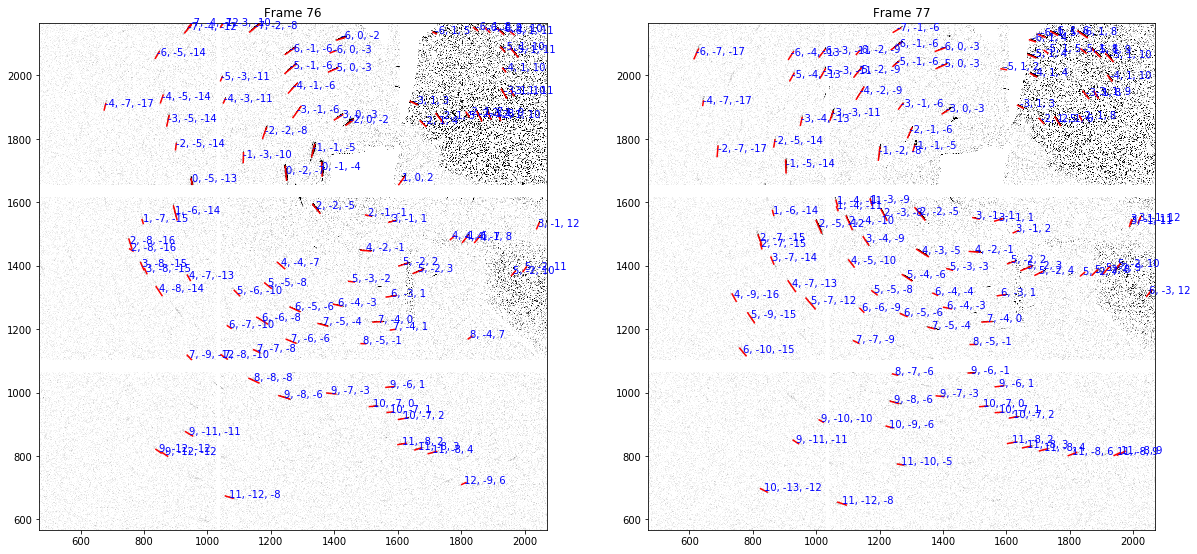

In [166]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[idx0], vmin=0, vmax=50, cmap='gray_r')
axes[1].imshow(b12_cor_data[idx1], vmin=0, vmax=50, cmap='gray_r')
for hkl, line in zip(hkl_list[idx0], b12_scan[idx0].raw_lines):
    axes[0].plot(line[:, 0], line[:, 1], 'r')
    axes[0].text(line[..., 0].mean(), line[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for hkl, line in zip(hkl_list[idx1], b12_scan[idx1].raw_lines):
    axes[1].plot(line[:, 0], line[:, 1], 'r')
    axes[1].text(line[..., 0].mean(), line[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for ax, frame_idx in zip(axes, [idx0, idx1]):
    ax.set_xlim(470, 2070)
    ax.set_ylim(567, 2167)
    ax.set_title('Frame {:d}'.format(frame_idx))
plt.show()

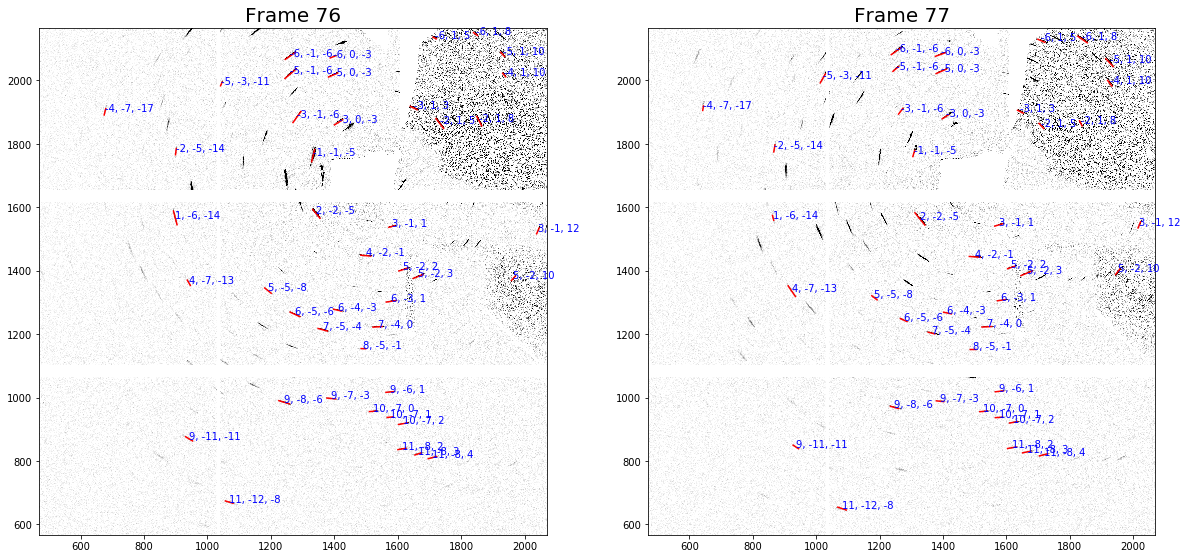

In [165]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(b12_cor_data[idx0], vmin=0, vmax=50, cmap='gray_r')
axes[1].imshow(b12_cor_data[idx1], vmin=0, vmax=50, cmap='gray_r')
for hkl in hkl0_arr[cidx0]:
    idxs = np.where((hkl_list[idx0] == hkl).all(axis=1))
    lines = b12_scan[idx0].raw_lines[idxs]
    for line in lines:
        axes[0].plot(line[:, 0], line[:, 1], 'r')
    axes[0].text(lines[..., 0].mean(), lines[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for hkl in hkl1_arr[cidx1]:
    idxs = np.where((hkl_list[idx1] == hkl).all(axis=1))
    lines = b12_scan[idx1].raw_lines[idxs]
    for line in lines:
        axes[1].plot(line[:, 0], line[:, 1], 'r')
    axes[1].text(lines[..., 0].mean(), lines[..., 1].mean(),
                 '{0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl), color='b')
for ax, frame_idx in zip(axes, [idx0, idx1]):
    ax.set_xlim(470, 2070)
    ax.set_ylim(567, 2167)
    ax.set_title('Frame {:d}'.format(frame_idx), fontsize=20)
plt.show()
# plt.savefig('figures/rot_groups.pdf')

In [141]:
thetas = np.radians(np.arange(101))
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-theta).T)
full_tf = cbc_dp.FCBI(lines=b12_frame.raw_lines,
                      exp_set=b12_exp,
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=([0.025, 0.025, 0.05], 0.12))
kins = full_tf.det_pts(hkl_list[idx1][idxs], champion)

In [37]:
def scale_coeffs(i_dict, hkl_dict):
    keys = list(i_dict)
    sc_list = []
    for idx0, idx1 in zip(keys[:-1], keys[1:]):
        hkl0_arr, hkl1_arr = hkl_dict[idx0], hkl_dict[idx1]
        cidx0, cidx1 = np.where((hkl0_arr[:, None] == hkl1_arr[None, :]).all(axis=-1))
        sc_list.append(np.median(i_dict[idx1][cidx1] / i_dict[idx0][cidx0]))
    return np.array(sc_list)

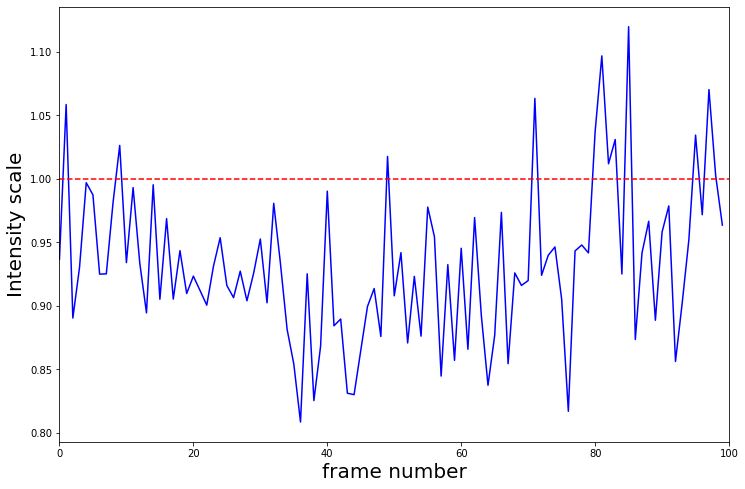

In [38]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
# ax.plot(convolve(scale_coeffs(i_dict, hkl_dict), np.ones(3) / 3), 'b')
ax.plot(scale_coeffs(i_dict, hkl_dict), 'b')
ax.plot(np.linspace(0, 100), np.ones(50), 'r--')
ax.set_xlim(0, 100)
ax.set_xlabel('frame number', fontsize=20)
ax.set_ylabel('Intensity scale', fontsize=20)
plt.show()
# plt.savefig('figures/int_scale.pdf')

# Frame streaks merging

In [84]:
frame_idx = 0
streaks = b12_scan[frame_idx]
rec_basis = rec_basis_full.dot(b12_exp.rotation_matrix(-np.radians(frame_idx)).T)
full_tf = cbc_dp.RCBI(streaks=streaks,
                      num_ap=pupil_size,
                      rec_basis=rec_basis,
                      tol=([0.007, 0.014, 0.06], 0.03, 1.5),
                      pen_coeff=10)
champion = index_sol[frame_idx]
hkl_arr = full_tf.hkl_idxs(champion)
hkl_uniq, hkl_cnt = np.unique(hkl_arr, axis=0, return_counts=True)
hkl_amb = hkl_uniq[hkl_cnt > 1]

In [ ]:
hkl_amb[]

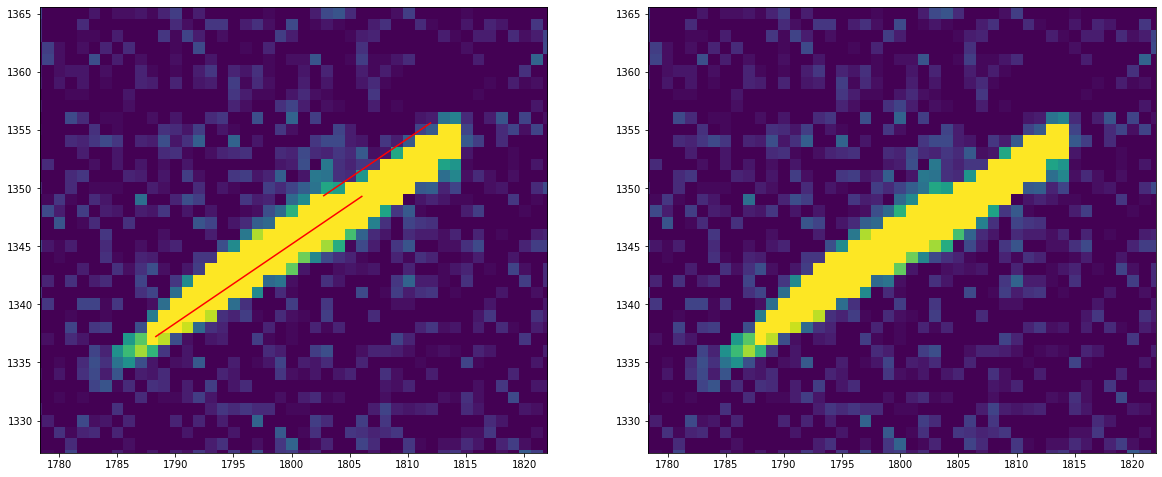

In [93]:
%matplotlib inline
hkl = hkl_amb[6]
idxs = np.where((hkl_arr == hkl).all(axis=-1))
offset = 10
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for line in streaks.raw_lines[idxs]:
    axes[0].plot(line[..., 0], line[..., 1], 'r')
axes[0].imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
axes[1].imshow(b12_cor_data[frame_idx], vmin=0, vmax=50)
for ax in axes:
    ax.set_xlim(streaks.raw_lines[idxs][..., 0].min() - offset,
                streaks.raw_lines[idxs][..., 0].max() + offset)
    ax.set_ylim(streaks.raw_lines[idxs][..., 1].min() - offset,
                streaks.raw_lines[idxs][..., 1].max() + offset)
plt.show()

# Streaks merging

In [51]:
%%cython
from cython cimport boundscheck, wraparound, cdivision
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, floor, ceil, atan2, atan, sin, cos, tan, acos

ctypedef cnp.float64_t float_t
ctypedef cnp.int64_t int_t
ctypedef cnp.uint8_t uint8_t
ctypedef cnp.uint64_t uint_t

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def merge_cython(int_t[:, ::1] hkl_arr, float_t[::1] i_arr, float_t[::1] s_arr):
    cdef:
        int_t a = hkl_arr.shape[0], ii = 0, i, j, k, cnt, flag
        float_t i_mean, i_var, delta, w, w2
        uint8_t[::1] mask = np.zeros(a, dtype=np.uint8)
        int_t[::1] cnts = np.empty(a, dtype=np.int64)
        int_t[:, ::1] hkl_m = np.empty((a, 3), dtype=np.int64)
        float_t[::1] i_m = np.empty(a, dtype=np.float64)
        float_t[::1] s_m = np.empty(a, dtype=np.float64)
    for i in range(a):
        if not mask[i]:
            hkl_m[ii] = hkl_arr[i]; mask[i] = 1; cnt = 1
            i_mean = i_arr[i]; i_var = 0; w = s_arr[i]**-2; w2 = s_arr[i]**-4
            for k in range(a):
                if k != i and hkl_arr[k, 0] == hkl_m[ii, 0] and hkl_arr[k, 1] == hkl_m[ii, 1] and hkl_arr[k, 2] == hkl_m[ii, 2]:
                    mask[k] = 1; cnt += 1; w += s_arr[k]**-2; w2 += s_arr[k]**-4
                    delta = i_arr[k] - i_mean
                    i_mean += delta * s_arr[k]**-2 / w
                    i_var += s_arr[k]**-2 * delta * (i_arr[k] - i_mean)
            i_m[ii] = i_mean; cnts[ii] = cnt
            if cnt > 1:
                s_m[ii] = sqrt(i_var / (w - w2 / w));
            else:
                s_m[ii] = s_arr[i]
            ii += 1
    return np.asarray(hkl_m[:ii]), np.asarray(cnts[:ii]), np.asarray(i_m[:ii]), np.asarray(s_m[:ii])

@boundscheck(False)
@wraparound(False)
@cdivision(True)
def symmetry_merge(int_t[:, :, ::1] rot_ops, int_t[:, ::1] hkl_arr, float_t[::1] i_arr, float_t[::1] s_arr):
    cdef:
        int_t a = hkl_arr.shape[0], b = rot_ops.shape[0], ii = 0, i, j, k, cnt, flag
        float_t i_mean, i_var, delta, w, w2
        uint8_t[::1] mask = np.zeros(a, dtype=np.uint8)
        int_t[::1] cnts = np.empty(a, dtype=np.int64)
        int_t[:, ::1] hkl_m = np.empty((a, 3), dtype=np.int64)
        int_t[:, ::1] sym_hkls = np.empty((b, 3), dtype=np.int64)
        float_t[::1] i_m = np.empty(a, dtype=np.float64)
        float_t[::1] s_m = np.empty(a, dtype=np.float64)
    for i in range(a):
        if not mask[i]:
            hkl_m[ii] = hkl_arr[i]; mask[i] = 1; cnt = 1
            i_mean = i_arr[i]; i_var = 0; w = s_arr[i]**-2; w2 = s_arr[i]**-4
            for j in range(b):
                sym_hkls[j, 0] = (hkl_m[ii, 0] * rot_ops[j, 0, 0] +
                                  hkl_m[ii, 1] * rot_ops[j, 0, 1] +
                                  hkl_m[ii, 2] * rot_ops[j, 0, 2])
                sym_hkls[j, 1] = (hkl_m[ii, 0] * rot_ops[j, 1, 0] +
                                  hkl_m[ii, 1] * rot_ops[j, 1, 1] +
                                  hkl_m[ii, 2] * rot_ops[j, 1, 2])
                sym_hkls[j, 2] = (hkl_m[ii, 0] * rot_ops[j, 2, 0] +
                                  hkl_m[ii, 1] * rot_ops[j, 2, 1] +
                                  hkl_m[ii, 2] * rot_ops[j, 2, 2])
            for k in range(a):
                if k != i:
                    flag = 0
                    for j in range(b):
                        flag += (sym_hkls[j, 0] == hkl_arr[k, 0] and
                                 sym_hkls[j, 1] == hkl_arr[k, 1] and
                                 sym_hkls[j, 2] == hkl_arr[k, 2])
                    if flag:
                        mask[k] = 1; cnt += 1; w += s_arr[k]**-2; w2 += s_arr[k]**-4
                        delta = i_arr[k] - i_mean
                        i_mean += delta * s_arr[k]**-2 / w
                        i_var += s_arr[k]**-2 * delta * (i_arr[k] - i_mean)
            i_m[ii] = i_mean; cnts[ii] = cnt
            if cnt > 1:
                s_m[ii] = sqrt(i_var / (w - w2 / w));
            else:
                s_m[ii] = s_arr[i]
            ii += 1
    return np.asarray(hkl_m[:ii]), np.asarray(cnts[:ii]), np.asarray(i_m[:ii]), np.asarray(s_m[:ii])

In [52]:
def merge(hkl_arr, i_arr, s_arr):
    hkl_uniq, hkl_counts = np.unique(hkl_arr, axis=0, return_counts=True)
    ws = 1 / s_arr**2
    hkl_idxs = np.where(hkl_counts > 1)
    i_m, s_m = [], []
    for hkl, hkl_count in zip(hkl_uniq, hkl_counts):
        idxs = np.where((hkl_arr == hkl).all(axis=1))
        if hkl_count > 1:
            ints, weights = i_arr[idxs], ws[idxs]
            i_mean = (ints * weights).sum() / weights.sum()
            s_mean = np.sqrt((weights * (ints - i_mean)**2).sum() /
                             (weights.sum() - (weights**2).sum() / weights.sum()))
            i_m.append(i_mean)
            s_m.append(s_mean)
        else:
            i_m.append(i_arr[idxs][0])
            s_m.append(s_arr[idxs][0])
    return hkl_uniq, hkl_counts, np.array(i_m), np.array(s_m)

def res_sort(rec_basis, hkl_m, cnts, i_m, s_m, wl=wavelength):
    rec_vec = hkl_m.dot(rec_basis)
    rec_abs = (rec_vec**2).sum(axis=-1) / wl * 1e-7
    sort_idxs = np.argsort(rec_abs)
    return hkl_m[sort_idxs], cnts[sort_idxs], i_m[sort_idxs], s_m[sort_idxs], np.sort(rec_abs)

In [53]:
import spglib

h_num = 115
rot_ops = spglib.get_symmetry_from_database(h_num)['rotations'].astype(np.int64)

In [54]:
hkl_m, cnts_m, i_m, s_m = merge_cython(hkl_flat, i_flat, s_flat)
hkl_sym, cnts_sym, i_sym, s_sym = symmetry_merge(rot_ops, hkl_flat, i_flat, s_flat)
hkl_m.shape, hkl_sym.shape

((5535, 3), (3936, 3))

In [55]:
hkl_m, cnts_m, i_m, s_m, rs = res_sort(rec_basis_full, hkl_m, cnts_m, i_m, s_m)
hkl_sym, cnts_sym, i_sym, s_sym, rs_sym = res_sort(rec_basis_full, hkl_sym, cnts_sym, i_sym, s_sym)

In [28]:
i_idx, f_idx = 1000, 1030
for hkl, cnt, i, s, r in zip(hkl_m[i_idx:f_idx], cnts_m[i_idx:f_idx], i_m[i_idx:f_idx], s_m[i_idx:f_idx], rs[i_idx:f_idx]):
    print('{0[0]:4d},{0[1]:4d},{0[2]:4d}:{1:6d}{2:14.2f}{3:16.2f}{4:8.2f}'.format(hkl, cnt, i, s, r))

   4,  -1,  -7:     1        697.15            6.79    0.11
  -4,   1,   7:     2        943.70          635.89    0.11
   0,  -5,  -8:     1        183.25   4159017342.55    0.11
   0,   8,   4:     1        698.26          101.13    0.11
  -4,  -1,   7:     2       1064.23          133.62    0.11
   1,  -3,  -9:     1        112.13            4.21    0.11
   5,  -4,  -3:     4        113.56           33.68    0.11
  -6,   0,   0:    14        615.68          249.24    0.11
   2,  -4,  -8:     1        342.08            3.28    0.11
  -2,   4,   8:     1        760.19           78.08    0.11
   3,  -3,   8:     2        447.46          203.94    0.11
   5,  -5,   0:     8        537.32          357.58    0.11
   4,  -6,  -3:     3         97.82           45.83    0.11
  -6,   0,  -1:     9        385.95          137.37    0.11
  -1,  -6,  -7:     1        903.59            4.90    0.11
   1,   6,   7:     1       1054.36          140.29    0.11
  -4,  -6,  -3:     1        121.65     

In [29]:
max_idx = 40
for hkl, cnt, i, s, r in zip(hkl_sym[:max_idx], cnts_sym[:max_idx], i_sym[:max_idx], s_sym[:max_idx], rs_sym[:max_idx]):
    print('{0[0]:4d},{0[1]:4d},{0[2]:4d}:{1:6d}{2:14.2f}{3:16.2f}{4:8.2f}'.format(hkl, cnt, i, s, r))

   0,   1,   1:     1      40609.79         2693.39    0.00
  -1,   0,  -1:     3        730.75          493.28    0.00
  -1,  -1,   0:     1      21011.67          212.52    0.00
   0,   0,   2:     2        620.56        43667.42    0.00
   1,   1,   1:     1      10863.04   2687913734.44    0.01
  -1,  -1,  -1:     3       9759.98         3586.64    0.01
   0,   1,   2:     1        277.56            8.90    0.01
   0,   2,   1:     2      15235.84        14697.30    0.01
  -1,   0,  -2:     8       1334.37          290.28    0.01
  -1,  -2,   0:     2        494.59             inf    0.01
   1,   1,   2:     1      13073.73   4559428688.63    0.01
  -1,  -1,  -2:     4      13415.11         5229.64    0.01
  -1,   2,   1:     4        239.68           55.05    0.01
   1,   2,   1:     2        203.32           -0.00    0.01
   0,   0,   3:     1       1510.78           10.17    0.01
   0,   1,   3:     2        871.80          451.02    0.01
  -2,   0,   0:     8       3965.76     

In [30]:
d_res = 0.1
limits = d_res * np.arange(rs_sym.min() // d_res, rs_sym.max() // d_res + 1)
sects = np.unique(np.searchsorted(limits, rs_sym), return_index=True)[1]
hkl_list = np.split(hkl_sym, indices_or_sections=sects[1:])
cnts_list = np.split(cnts_sym, indices_or_sections=sects[1:])
i_list = np.split(i_sym, indices_or_sections=sects[1:])
s_list = np.split(s_sym, indices_or_sections=sects[1:])
abs_list = np.split(rs_sym, indices_or_sections=sects[1:])

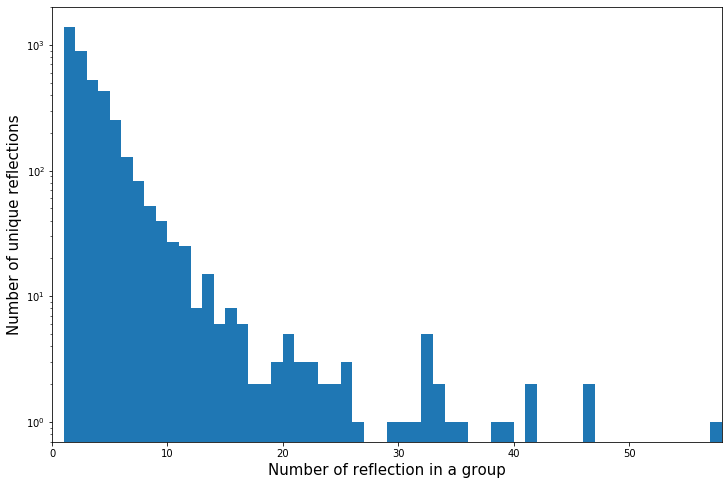

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.hist(cnts_sym, bins=np.arange(0, hkl_counts.max() + 1), log=True)
ax.set_xlabel('Number of reflection in a group', fontsize=15)
ax.set_ylabel('Number of unique reflections', fontsize=15)
ax.set_xlim(0, hkl_counts.max())
# plt.show()
plt.savefig('figures/hkl_hist.pdf')

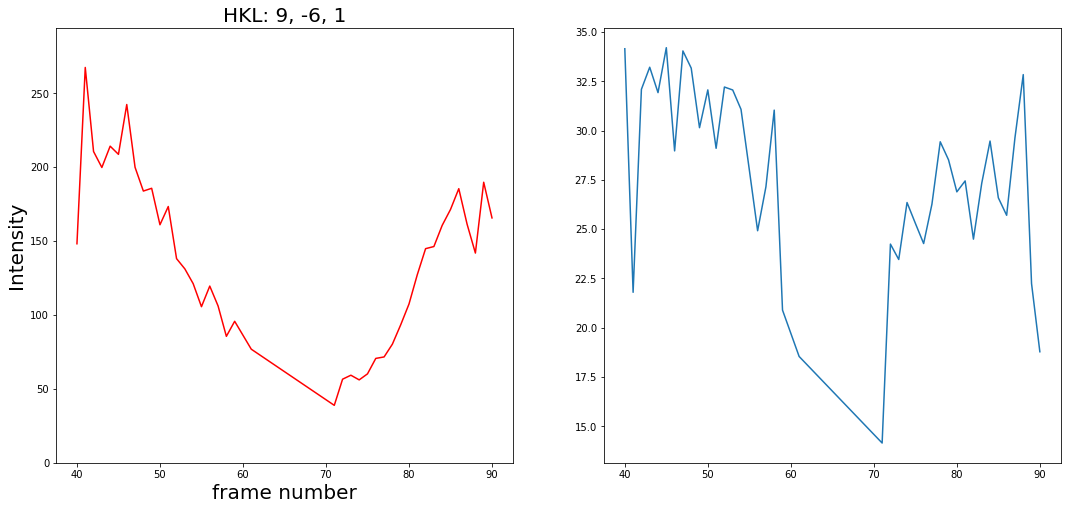

In [65]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sort_idxs = np.argsort(cnts_m)[::-1]
hkl_max = hkl_m[sort_idxs[3]]
idxs = np.where((hkl_flat == hkl_max).all(axis=-1))
axes[0].plot(scan_idxs[idxs], i_scan[idxs], 'r')
axes[0].set_ylim(0, 1.1 * i_scan[idxs].max())
axes[0].set_xlabel('frame number', fontsize=20)
axes[0].set_ylabel('Intensity', fontsize=20)
axes[0].set_title('HKL: {0[0]:d}, {0[1]:d}, {0[2]:d}'.format(hkl_max), fontsize=20)
axes[1].plot(scan_idxs[idxs], len_scan[idxs])
plt.show()
# plt.savefig('figures/hkl_group.pdf')

In [ ]:
kin_list

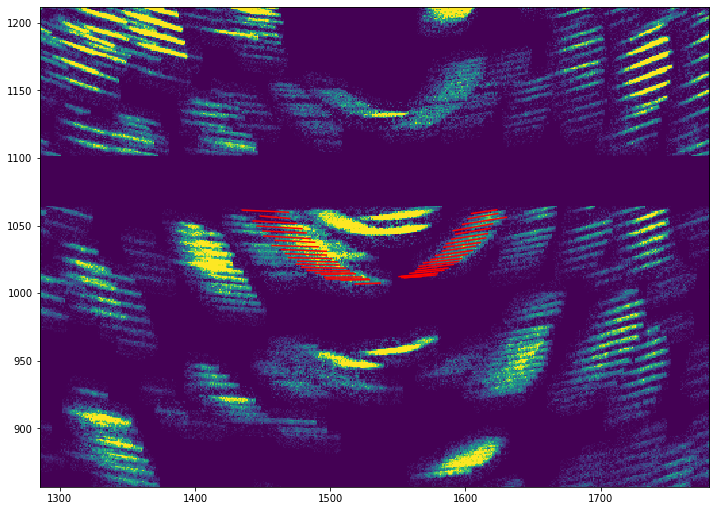

In [57]:
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
idxs = np.where((hkl_arr == hkl_max).all(axis=-1))
lines = b12_scan.raw_lines[idxs]
for line in lines:
    ax.plot(line[:, 0], line[:, 1], 'r')
ax.imshow((b12_cor_data[frame_idxs[idxs]] * b12_streaks_mask[frame_idxs[idxs]]).sum(axis=0), vmin=0, vmax=100)
offset = 150
ax.set_xlim(lines[..., 0].min() - offset, lines[..., 0].max() + offset)
ax.set_ylim(lines[..., 1].min() - offset, lines[..., 1].max() + offset)
plt.show()

In [58]:
hkl1, _, i1_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_flat[::2]),
                                  i_arr=np.ascontiguousarray(i_flat[::2]),
                                  s_arr=np.ascontiguousarray(s_flat[::2]))
hkl2, _, i2_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_flat[1::2]),
                                  i_arr=np.ascontiguousarray(i_flat[1::2]),
                                  s_arr=np.ascontiguousarray(s_flat[1::2]))
cidxs1, cidxs2 = np.where((hkl1[:, None] == hkl2[None, :]).all(axis=-1))
i1_c, i2_c = i1_m[cidxs1], i2_m[cidxs2]
r_split = np.abs(i1_c - i2_c).sum() / (i1_c + i2_c).sum() * np.sqrt(2)
print(r_split)

0.412234319445522


In [61]:
hkl_mult = hkl_sym[cnts_sym > 9]
idxs_mult = np.where((hkl_flat[:, None] == hkl_mult[None, :]).all(axis=-1).any(axis=1))
hkl_mult, i_mult, s_mult = hkl_flat[idxs_mult], i_flat[idxs_mult], s_flat[idxs_mult]

In [62]:
hkl1, _, i1_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_mult[::2]),
                                  i_arr=np.ascontiguousarray(i_mult[::2]),
                                  s_arr=np.ascontiguousarray(s_mult[::2]))
hkl2, _, i2_m, _ = symmetry_merge(rot_ops=rot_ops,
                                  hkl_arr=np.ascontiguousarray(hkl_mult[1::2]),
                                  i_arr=np.ascontiguousarray(i_mult[1::2]),
                                  s_arr=np.ascontiguousarray(s_mult[1::2]))
cidxs1, cidxs2 = np.where((hkl1[:, None] == hkl2[None, :]).all(axis=-1))
i1_c, i2_c = i1_m[cidxs1], i2_m[cidxs2]
r_split = np.abs(i1_c - i2_c).sum() / (i1_c + i2_c).sum() * np.sqrt(2)
print(r_split)

0.2581203158193209


In [88]:
with open('exp_results/hkl_list.txt', 'w') as file:
    file.write('h\tk\tl\tres\tI\tsigma(I)\tnmeas\n')
    for hkl, res, i, s, cnt in zip(hkl_uniq, rec_abs, i_m, s_m, counts):
        file.write('{0[0]:+8d}{0[1]:+8d}{0[2]:+8d}{1:+10.2f}{2:+10.2f}{3:+10.2f}{4:+8d}\n'.format(hkl, res, i, s, cnt))

# Gaussian beam

In [38]:
def thdiv(waist, wavelength):
    return wavelength / np.pi / waist

def zR(waist, wavelength):
    return np.pi * waist**2 / wavelength

def R(zs, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    return zs + zr**2 / zs

def wz(z, waist, wavelength):
    return waist * np.sqrt(1 + (z / zR(waist, wavelength)**2))

def gaussian(xs, ys, zs, waist=1e-4, wavelength=1.5e-7):
    k = 2 * np.pi / wavelength
    zr = np.pi * waist**2 / wavelength
    Rs = zs + zr**2 / zs
    wz = waist * sqrt(1 + z**2 / zr**2)
    return np.pi**-1 * waist**-1 * wz**-1 * np.exp(-(xs**2 + ys**2) / wz**2) * np.exp(-1j * (k * z - np.arctan(zs / zr) + k * (xs**2 + ys**2) / 2 / Rs))

In [39]:
thdiv(waist, wavelength)

0.0477464829275686

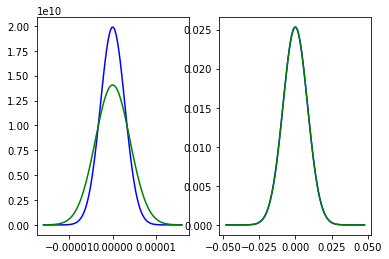

In [50]:
%matplotlib inline
xs = np.linspace(-4 * waist, 4 * waist, 100)
us = np.abs(cbc.gaussian(xs, 0, 0, waist, wavelength))
us2 = np.abs(cbc.gaussian(xs, 0, zR(waist, wavelength), waist, wavelength))
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
ufs = np.abs(cbc.gaussian_f(kxs, 0, 0, waist, wavelength))
ufs2 = np.abs(cbc.gaussian_f(kxs, 0, zR(waist, wavelength), waist, wavelength))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xs, us, 'b-', xs, us2, 'g-')
ax2.plot(kxs, ufs, 'b-', kxs, ufs2, 'g-')
plt.show()

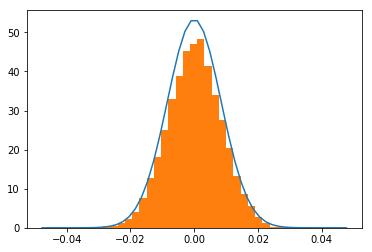

In [34]:
%matplotlib inline
knum = 10000
ks = cbc.gaussian_dist(knum, 0, waist, wavelength)
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength))
us = np.abs(cbc.gaussian_f(kxs, 0, 10, waist, wavelength)) * 4 * np.pi / thdiv(waist, wavelength)*2
plt.plot(kxs, us)
plt.hist(ks[:,0], 30, density=True)
plt.show()

In [ ]:
%matplotlib inline
_thdiv = thdiv(waist,wavelength)
kxs, kys = cbc.uniform_dist(100000, waist, wavelength)[:, 0:2].T
kxs2, kys2 = cbc.gaussian_dist(100000, waist, wavelength)[:, 0:2].T
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.hist2d(kxs, kys, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
ax2.hist2d(kxs2, kys2, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
plt.show()

# Convolution approximation and Henry's equations

In [3]:
def gaussian_dist(N, z, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    wz = waist * np.sqrt(1 + z**2 / zr**2)
    thdiv = wavelength / np.pi / wz
    kxs, kys = np.random.multivariate_normal([0, 0], [[thdiv**2 / 2, 0], [0, thdiv**2 / 2]], N).T
    return cbc.kout_parax(kxs, kys)

In [40]:
waist = 3e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 10, 10, 1
detNx, detNy = 64, 64
pix_size = 2 * 55e-3
det_dist = 30
knum = 5000

In [4]:
%matplotlib inline
XS, YS, ZS = np.array([0, 0.5 * a]), np.zeros(2), np.zeros(2)
els = ['Au', 'Ag']; bs = np.zeros(2)
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz, XS, YS, ZS)
z0 = 1e-4
zs += z0
asf_coeffs = cbc.asf_coeffs(els, bs)
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
us = cbc.gaussian(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)
print(asf_coeffs.shape)

(2, 11)


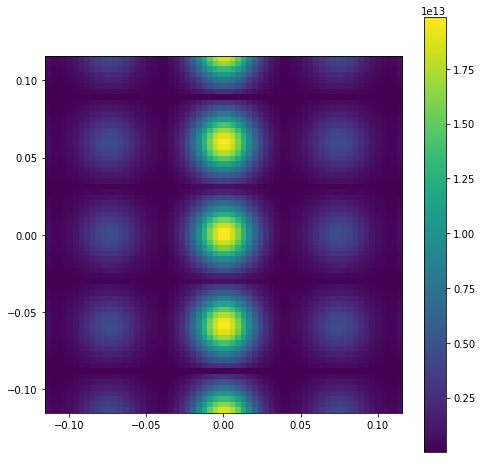

In [80]:
qabs = cbc.utils.q_abs(kouts, kins, wavelength)
asfs = cbc.utils.asf_sum(qabs, asf_coeffs)
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs * us * phs).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(8, 8))
plt.imshow(ints, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

In [81]:
%time kjs = np.repeat(cbc.gaussian_dist(knum, waist, wavelength)[:,np.newaxis], xs.shape[-1], axis=1)
%time qabs2 = cbc.utils.q_abs(kouts, kjs, wavelength)
%time asfs2 = cbc.utils.asf_sum(qabs2, asf_coeffs)
%time phs2 = cbc.utils.phase_conv(kouts, kjs, xs, ys, zs, wavelength)
%time sfs2 = asfs2 * phs2
print(kjs.shape, qabs2.shape, asfs2.shape, phs2.shape)

CPU times: user 1.13 ms, sys: 533 µs, total: 1.66 ms
Wall time: 1.13 ms
CPU times: user 480 ms, sys: 203 ms, total: 683 ms
Wall time: 680 ms
CPU times: user 2.03 s, sys: 102 ms, total: 2.13 s
Wall time: 2.12 s
CPU times: user 1min 16s, sys: 416 ms, total: 1min 17s
Wall time: 1min 16s
CPU times: user 248 ms, sys: 197 ms, total: 445 ms
Wall time: 443 ms
(5000, 2, 3) (4096, 5000, 2) (4096, 5000, 2) (4096, 5000, 2)


In [82]:
uphs = cbc.gaussian_f(kjs[:,:,0], kjs[:,:,1], z0, waist, wavelength)
res2 = (uphs * sfs2).sum(axis=(-2,-1)).reshape(kxs.shape) / kjs.shape[0]
print(uphs.shape, res2.shape)

(5000, 2) (64, 64)


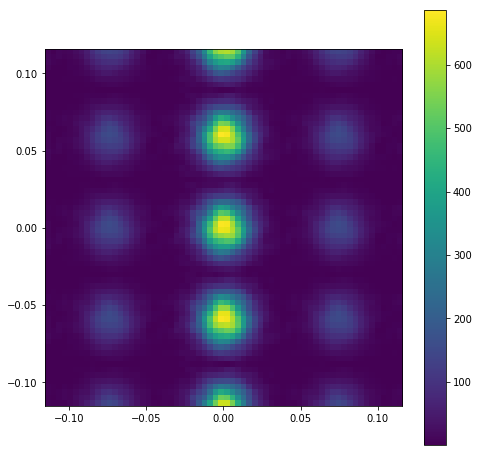

In [83]:
ints2 = np.abs(res2)
plt.figure(figsize=(8, 8))
plt.imshow(ints2, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

# Lysozyme diffraction pattern

In [42]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2.2e-2, 1e-4
waist = 4.5e-6
a, b, c = np.array([7.9e-6, 0, 0]), np.array([0, 7.9e-6, 0]), np.array([0, 0, 3.8e-6])
Nx, Ny, Nz = 20, 20, 20
r = 2e-4
detNx, detNy = 512, 512
pix_size = 55e-3
det_dist = 60

In [44]:
bragg = wavelength / 2 / np.sqrt(a.dot(a))
th_lens = 2 * ap / f
th_lens2 = 2 * wavelength / np.pi / waist
print(2 * bragg / th_lens, 2 * bragg / pix_size * det_dist)

0.863060989643268 20.713463751438432


In [45]:
beam = cbc.CircBeam(f, ap, wavelength)
diff = cbc.Diff(beam=beam,
                detector=cbc.Detector(det_dist=det_dist, detNx=detNx, detNy=detNy, pix_size=pix_size),
                lattice=cbc.BallLattice(cell=cbc.Cell.importpdb('4et8.pdb'), a=a, b=b, c=c, r=r))

In [ ]:
diffres = diff.calculate().pool()
diffres.write()

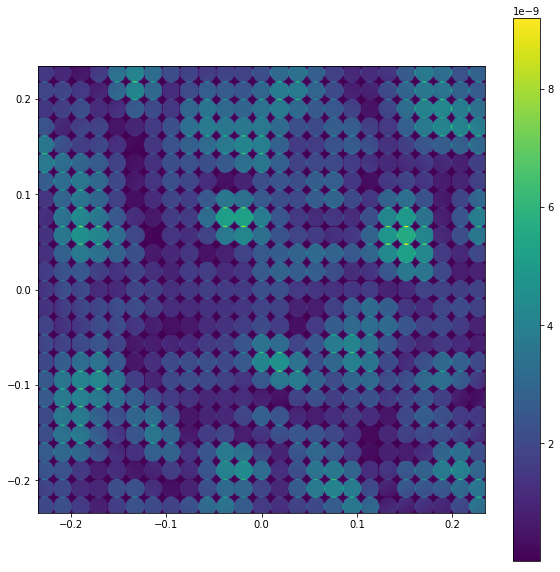

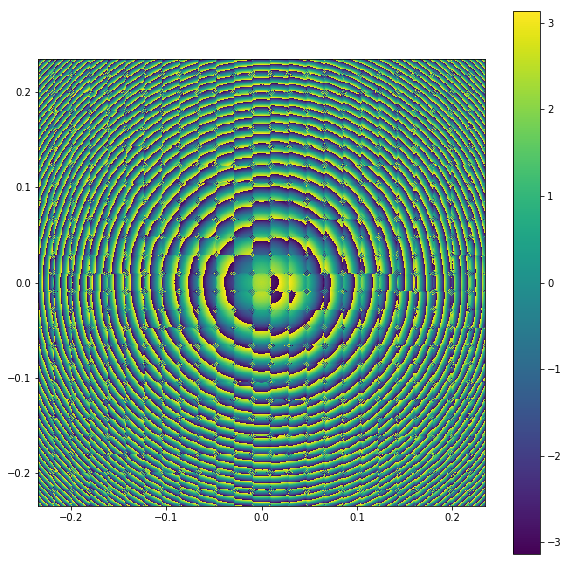

In [76]:
ints = np.abs(data[0])
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()
ang1 = np.angle(data[0])
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

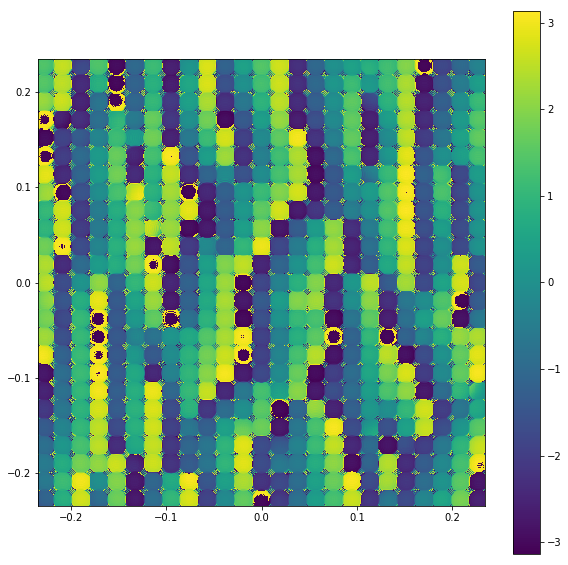

In [157]:
ang2 = np.angle(data[0] / np.exp(2j * np.pi / wavelength * 1e-4 * (1 - (data[1]**2 + data[2]**2) / 2)))
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

# Output values at the centers of diffraction orders

In [19]:
import numba as nb
from math import exp, cos, sin, pi

In [24]:
@nb.njit(nb.float64[:,:](nb.float64[:], nb.float64[:,:]), fastmath=True)
def asf_sum(ss, asfcoeffs):
    a = ss.size
    b = asfcoeffs.shape[0]
    asfs = np.empty((a, b), dtype=np.float64)
    ss = np.ascontiguousarray(ss)
    asfcoeffs = np.ascontiguousarray(asfcoeffs)
    for i in range(a):
        for j in range(b):
            dasf = 0.0
            for k in range(5):
                dasf += asfcoeffs[j,k] * exp(-ss[i]**2 * asfcoeffs[j,6+k])
            asfs[i,j] = (dasf + asfcoeffs[j,5]) * exp(-ss[i]**2 * asfcoeffs[j,-1])
    return asfs

@nb.njit(nb.complex128[:,:](nb.float64[:,:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64), fastmath=True)
def phase(kouts, xs, ys, zs, wavelength):
    a = kouts.shape[0]
    b = xs.size
    res = np.empty((a, b), dtype=np.complex128)
    kouts = np.ascontiguousarray(kouts)
    xs = np.ascontiguousarray(xs)
    ys = np.ascontiguousarray(ys)
    zs = np.ascontiguousarray(zs)
    for i in range(a):
        for j in range(b):
            _ph = kouts[i,0] * xs[j] + kouts[i,1] * ys[j] + kouts[i,2] * zs[j]
            res[i,j] = cos(2 * pi / wavelength * _ph) + sin(2 * pi / wavelength * _ph) * 1j
    return res

def gaussian_f(kxs, kys, zs, wavelength):
    return np.exp(-2j * np.pi / wavelength * np.multiply.outer((kxs**2 + kys**2) / 2, zs))

In [11]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2e-2, 1e-4
waist = 6.5e-6
a, b, c = 7.9e-6, 7.9e-6, 3.8e-6
Nx, Ny, Nz = 20, 20, 1
H, K = 10, 10
pix_size = 1/a
det_dist = 1/wavelength

In [28]:
XS = np.array([-0.5*a, -0.5*a, 0.5*a, 0.5*a])
YS = np.array([-0.5*a, 0.5*a, -0.5*a, 0.5*a])
ZS = np.array([-0.9*c, -0.9*c, 0.9*c, 0.9*c])
bs = np.repeat(25, 4)
elems = ['Au', 'Ag', 'Au', 'Ag']

In [7]:
XS = np.array([-0.5*a, 0.5*a])
YS = np.array([0.5*a, -0.5*a])
ZS = np.array([-0.9*c, 0.9*c])
bs = np.repeat(25, 2)
elems = ['Au', 'Ag']

In [29]:
beam = cbc.GausBeam(waist, wavelength)
diff = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff.move_lat([0.5 * a, 0.5 * b, 1e-3])

In [30]:
diffres = diff.henry().pool()
res, kxs, kys = diffres.res, diffres.kxs, diffres.kys

In [31]:
XS, YS, ZS, bs, elems = cbc.utils.pdb.importpdb('4et8.pdb')
gxs, gys = cbc.det_kouts(det_dist=det_dist, detNx=2*H+1, detNy=2*K+1, pix_size=pix_size)
gs = np.stack((gxs.ravel(), gys.ravel(), np.repeat(0, gxs.size)), axis=-1)
ss = np.sqrt(gs*gs).sum(axis=-1) / wavelength / 2e7
asfcoeffs = cbc.asf_coeffs(elems, bs, wavelength)
asfs = asf_sum(ss.ravel(), asfcoeffs)
phs = phase(gs, XS, YS, ZS, wavelength)
ufs = gaussian_f(gxs.ravel(), gys.ravel(), ZS, wavelength)
Fs = (asfs * phs * ufs).sum(axis=-1).reshape(gxs.shape)
print(asfs.shape, phs.shape, ufs.shape, Fs.shape)

(441, 1001) (441, 1001) (441, 1001) (21, 21)


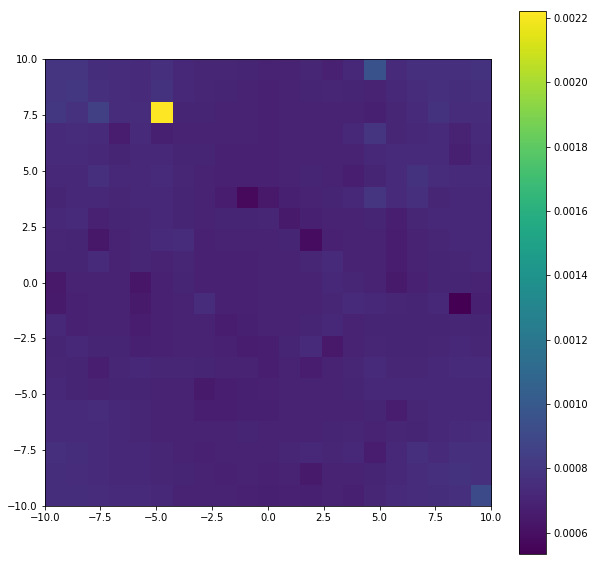

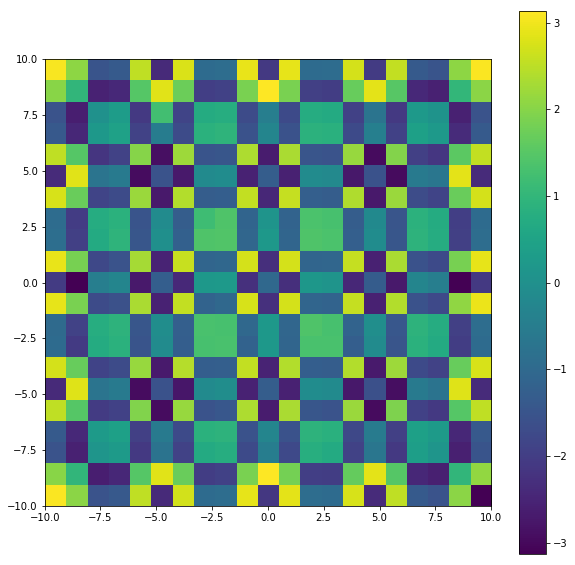

In [32]:
ints2 = np.abs(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ints2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang2 = np.angle(res/Fs)
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

# Output values in overlap regions

In [153]:
diff2 = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=2*H, detNy=2*K+1, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff2.move_lat([0.5 * a, 0.5 * b, 0.0])

In [154]:
diffres2 = diff2.henry().pool()
res2, kxs2, kys2 = diffres2.res, diffres2.kxs, diffres2.kys

In [142]:
kouts = cbc.kout_parax(kxs2.ravel(), kys2.ravel())
gxs1, gys1 = gxs[:, 0:2*H], gys[:, 0:2*H]
gxs2, gys2 = gxs[:, 1:2*H+1], gys[:, 1:2*H+1]
gs1 = np.stack((gxs1.ravel(), gys1.ravel(), np.repeat(0, gxs1.size)), axis=-1)
gs2 = np.stack((gxs2.ravel(), gys2.ravel(), np.repeat(0, gxs2.size)), axis=-1)
ss1 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
ss2 = np.sqrt(gs1*gs1).sum(axis=-1) / wavelength / 2e7
asfs1 = asf_sum(ss1.ravel(), asfcoeffs)
asfs2 = asf_sum(ss2.ravel(), asfcoeffs)
phs1 = phase(gs1, XS, YS, ZS, wavelength)
phs2 = phase(gs2, XS, YS, ZS, wavelength)
ufs1 = gaussian_f(gxs1.ravel(), gys1.ravel(), ZS, wavelength)
ufs2 = gaussian_f(gxs2.ravel(), gys2.ravel(), ZS, wavelength)
Fs1 = (asfs1 * phs1 * ufs1).sum(axis=-1).reshape(gxs1.shape)
Fs2 = (asfs2 * phs2 * ufs2).sum(axis=-1).reshape(gxs2.shape)
OLs = Fs1 + Fs2

In [10]:
ints4 = np.abs(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ints4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang4 = np.angle(OLs)
plt.figure(figsize=(10,10))
plt.imshow(ang4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

NameError: name 'OLs' is not defined

# Lens beam

In [70]:
wavelength = 1.5e-7
f, ap, defoc = 2, 8e-2, 1e-4
a, b, c = 2e-6, 2e-6, 1e-5
Nx, Ny, Nz = 60, 60, 1
detNx, detNy = 128, 128
pix_size = 55e-3 / 2
det_dist = 30

In [71]:
print(wavelength / a, 2 * ap / f)

0.075 0.08


In [79]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
zs += 1e-4
xs -= 0.5001 * a
ys -= 0.5001 * b
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
Rs = np.sqrt(xs**2 + ys**2 + zs**2)
kins = cbc.lensbeam_kins(xs, ys, zs, f, wavelength)
us = cbc.cbeam(xs, ys, zs, f, ap, wavelength)

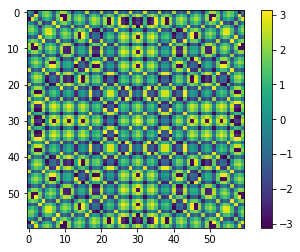

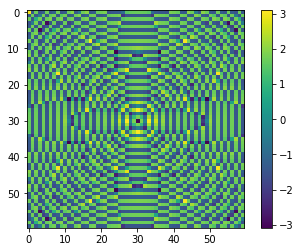

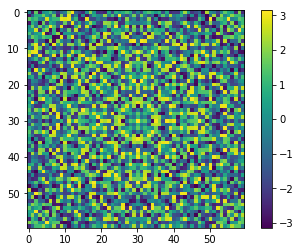

In [80]:
phin1 = (np.exp(1j) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)).reshape((Nx, Ny))
angs1 = np.angle(phin1)
angs2 = np.angle(np.exp(1j * np.pi) * np.exp(-1j * np.pi * 1e-2 / wavelength * (xs**2 + ys**2) / Rs**2)).reshape((Nx, Ny))
angs3 = -np.angle(us).reshape(Nx, Ny)
plt.imshow(angs1)
plt.colorbar()
plt.show()
plt.imshow(angs3)
plt.colorbar()
plt.show()
plt.imshow(angs2)
plt.colorbar()
plt.show()

In [82]:
qs_abs = cbc.utils.q_abs(kouts, kins, wavelength)
asf_coeffs1 = cbc.asf_coeffs()
%time asfs1 = cbc.utils.asf_sum(qs_abs, asf_coeffs1)
qs_abs.shape

CPU times: user 3.03 s, sys: 141 ms, total: 3.17 s
Wall time: 3.16 s


(16384, 3600, 1)

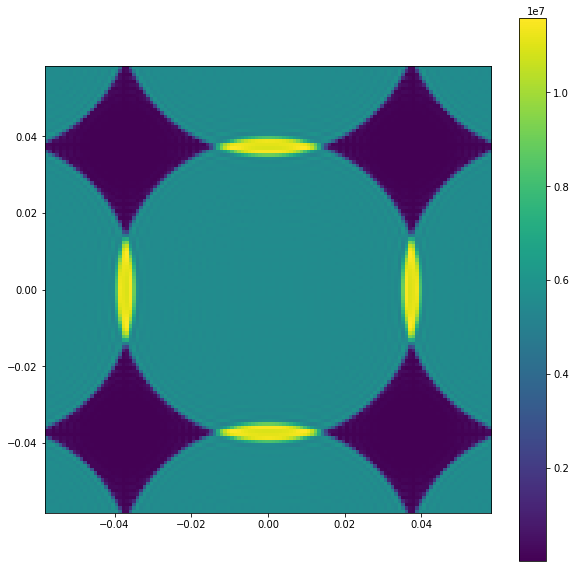

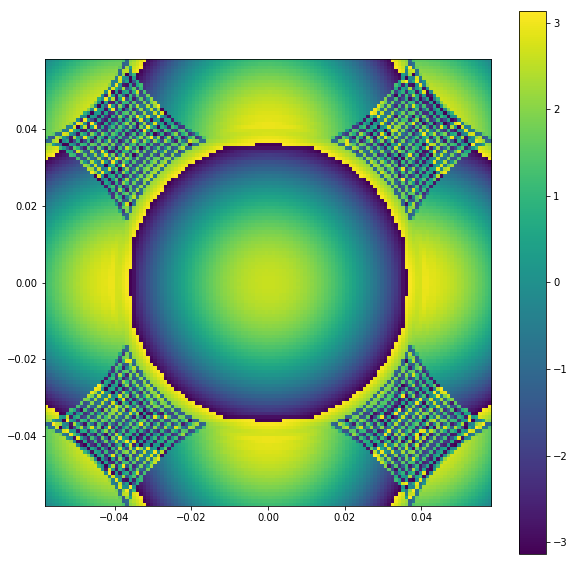

In [85]:
%matplotlib inline
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs1 * phs * us).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()
ang1 = np.angle(res)
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

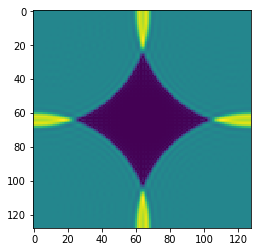

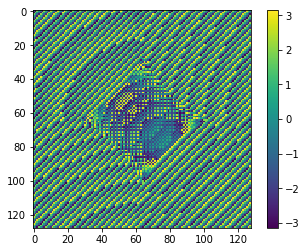

In [86]:
res2 = np.fft.fft2(us.reshape((Nx, Ny)), kxs.shape)
ints2 = np.abs(res2)
plt.imshow(ints2)
plt.show()
ang2 = np.angle(res2)
plt.imshow(ang2)
plt.colorbar()
plt.show()